# Cobinding PiPeline: pre processing & analysis

In [390]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../..')
import itertools
from scipy import stats

import numpy as np

from JKBio.epigenetics import chipseq as chip
from JKBio.utils import helper
from JKBio.utils import plot
from JKBio.google import gcp
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
project="Cobinding_ChIP"
version="v3"

## processing using Nextflow

In [78]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/paired_end/*MV411* # all other cell lines don't have the right INPUT
fastq

['gs://amlproject/Chip/fastqs/paired_end/mp299-MV411-CEBPA-r3_S7_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp299-MV411-CEBPA-r3_S7_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp300-MV411-RUNX1-r3_S8_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp300-MV411-RUNX1-r3_S8_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp301-MV411-PU1-r2_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp301-MV411-PU1-r2_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp319-MV411-FLI1-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp319-MV411-FLI1-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp320-MV411-ZEB2-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp320-MV411-ZEB2-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp321-MV411-GFI1-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp321-MV411-GFI1-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp324-MV411-MEF2D-r1_R1.fastq.gz',
 'gs://aml

In [94]:
from gsheets import Sheets
# Here you might not need this line, otherwise you need to generate your json files from 
# https://pygsheets.readthedocs.io/en/stable/authorization.html
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()

In [80]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in helper.grouped(fastq,2):
    row = gsheet[gsheet.id==val[0].split('/')[-1].split('-')[0]]
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val[0])
    df['fastq_2'].append(val[1])
    if row['matching input name'].values[0] is not None:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_paired_end_design.csv',index=False)

In [97]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/*.gz
fastq

['gs://amlproject/Chip/fastqs/db28-MV411-H3K18-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db29-MV411-AFF4-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db30-MV411-CDK9-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db31-MV411-PSER2-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db32-MV411-INPUT-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db33-MV411-INPUT-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db34-MV411-CEBPB-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db35-MV411-INPUT-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db36-MV411-INPUT-r4.fastq.gz',
 'gs://amlproject/Chip/fastqs/db37-MV411-WDR5_429A-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db38-MV411-WDR5_429A-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db39-MV411-WDR5_429A-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db40-MV411-WDR5_D9E1-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db41-MV411-WDR5_D9E1-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db42-MV411-WDR5_D9E1-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db43-MV411-IGG-r1.fastq.gz',
 'gs

In [98]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] in ["IRF2BP2", "H3K27ac", "H3K36me3", "H3K27me3", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "H3K18", "BRD4"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_np.csv',index=False)

In [93]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] not in ['INPUT',"IGG","IRF2BP2", "H3K27ac", "CEBPA", "H3K36me3", "PU1", "H3K27me3", "SMC1", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "CEBPB", "H3K18", "BRD4", "WDR5"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_bp.csv',index=False)

## Pipeline

![](images/gcpjup.png)


- Raw read QC (FastQC)
- Adapter trimming (Trim Galore!)
- Alignment (BWA)
- Mark duplicates (picard)
- Merge alignments from multiple libraries of the same sample (picard)
- Re-mark duplicates (picard)
- Filtering to remove: blacklisted regions, duplicates, primary alignments,unmapped,multiple locations, containing >  4 mismatches, insert size > 2kb, map to different chromosomes 
- Alignment-level QC and estimation of library complexity (picard, Preseq)
- Create normalised bigWig files scaled to 1 million mapped reads (BEDTools, bedGraphToBigWig)
- Generate gene-body meta-profile from bigWig files (deepTools)
- Calculate genome-wide IP enrichment relative to control (deepTools)
- Calculate strand cross-correlation peak and ChIP-seq quality measures including NSC and RSC (phantompeakqualtools)
- Call broad/narrow peaks (MACS2)
- Annotate peaks relative to gene features (HOMER)
- Create consensus peakset across all samples and create tabular file to aid in the filtering of the data (BEDTools)
- Count reads in consensus peaks (featureCounts)

![](images/nfcore.png)


## about
0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`
3. you will export the credentials to your google account (see google cloud oauth) `export GOOGLE_APPLICATION_CREDENTIALS=aml-chipseq-rnaseq-9dcbe47182cf.json`
4. look more about the chipseq pipeline here: https://nf-co.re/chipseq
5. now you can run the code as below (to run it locally, use `-profile docker`)
6. to run it on google cloud make a conf file with your google paymnt project id: `echo "google.project = 'YOUR_GOOGLE_PROJECT_ID'" >> my.config` and run the pipeline using: `-profile jkcloud --custom_local_config my.config`
7. to run it elsewhere, look at nf-core's documentation

In [ ]:
-profile #my profile for the cloud (to edit for your account) jkcloud
-w #where the withinput will be stored
--outdir #specify aa bucket+folderr where the results will be
--tracedir #you need to specify a local place for that
--custom_local_config custom_local.config #yoour custtom config

In [66]:
#process chips 
! ../../nextflow run jkobject/chipseq --paired_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_paired_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingp --outdir gs://workamlproject/cobindingpres --tracedir ../nextflow/cobindingp/ --narrow_peak

.nextflow/history.lock (Permission denied)


In [ ]:
#calling narrow peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindings --outdir gs://workamlproject/cobindingsres --tracedir ../nextflow/cobindings/ --narrow_peak

In [ ]:
#calling broad peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_broad_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingsb --outdir gs://workamlproject/cobindingsbres --tracedir ../nextflow/cobindingsb/

## Gathering data

we are using a folder outside our repository as there is too many huge files.

In [105]:
! gsutil -m cp -r gs://workamlproject/cobindingpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_pe_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [106]:
! gsutil -m cp -r gs://workamlproject/cobindingsbpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_bp.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/broadPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db28-MV411-H3K18_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db33-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db35-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db43-MV411-IGG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db32-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db45-MV411-IGG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db34-MV411-CEBPB_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp5-D9-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp50-OCIAML2-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp53-HL60-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp56-Kasumi1-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp575-MV411-IRF2BP2_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp577-MV411-SMC1_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp58-KG1-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workam

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/db52-MV411-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/db53-MV411-H3K9ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/db54-MV411-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp100-U937-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp101-NOMO1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp102-UT7-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp315-MONOMAC6-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp316-SKNO1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp326-DFAM71927V3-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp35-D9-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp33-OCIAML2-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp351-D0-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibra

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp77-HL60-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp776-P31FUJ-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp777-MONOMAC1-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp778-MONOMAC1-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp8-D0-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp88-MV411-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedL

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp213-U937-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp214-UT7-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp216-SKNO1-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp217-HEL-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp218-HEL-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp231-SKNO1-CEBPA_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp24-OCIAML2-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp718-MV411-IRF2BP2_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp72-MV411-CEBPA_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp728-MV411_DMSO-CEBPA_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp73-U937-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp734-MV411_DMSO-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp752-SHI1-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp754-EOL1-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db51-MV411-H3K36me2_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db52-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db53-MV411-H3K9ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db53-MV411-H3K9ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db54-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db54-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp154-D9-PU1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp154-D9-PU1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp157-D9-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp157-D9-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp157-D9-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp160-D9-MED1_R1.plotFingerprint.pdf 

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp354-D9-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp354-D9-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp354-D9-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp355-M6-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp355-M6-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp355-M6-H3K27ac_R1.plotFingerpri

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp591-MONOMAC1-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp592-MONOMAC1-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp592-MONOMAC1-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp592-MONOMAC1-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp593-HEL9217-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp593-HEL9

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp88-MV411-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp88-MV411-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp89-MV411-H3K36me3_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp89-MV411-H3K36me3_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp89-MV411-H3K36me3_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp90-U937-H3K27a

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://w

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db54-MV411-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db54-MV411-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp120-HL60-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp120-HL60-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.plotHeatmap.pdf [Content-Type=application/oct

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp204-TF1-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp204-TF1-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp217-HEL-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp217-HEL-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp311-MOLM13-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp352-D0-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp53-HL60-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.plotProfile.pdf [Content-Type=applicatio

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotProfile.tab [Content-Type=applica

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp734-MV411_DMSO-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp734-MV411_DMSO-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp734-MV411_DMSO-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp752-SHI1-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp752-SHI1-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp752-SHI1-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=a

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp77-HL60-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp77-HL60-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/o

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workaml

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.intersect.plot.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.featureCounts.tx

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp115-MV411-PU1_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp128-M6-MED1_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broa

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp193-NB4-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp193-NB4-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp217-HEL-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp217-HEL-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsb

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp430-MV411-IRF2BP2_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp430-MV411-IRF2BP2_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp430-MV411-IRF2BP2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp431-MV411-IRF2BP2_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp431-MV411-IRF2BP2_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp431-MV411-IRF2BP2_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpre

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp593-HEL9217-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp593-HEL9217-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindin

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp734-MV411_DMSO-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp734-MV411_DMSO-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bw

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp204-TF1-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp204-TF1-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp205-OCIAML3-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp205-OCIAML3-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp206-MONOMAC6-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp206-MONOMAC6-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
C

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp56-Kasumi1-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp56-Kasumi1-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp575-MV411-IRF2BP2_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp577-MV411-SMC1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp575-MV411-IRF2BP2_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp577-MV411-SMC1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp102-UT7-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp102-UT7-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp109-M6-CEBPA_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp109-M6-CEBPA_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp112-MV411-CEBPA_R1.mLb.clN.sorted.bam [Content-Type=application/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp197-SKNO1-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp197-SKNO1-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp2-D9-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp2-D9-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp204-TF1-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=appl

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp355-M6-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp356-M6-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp356-M6-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp4-D9-IGG_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp4-D9-IGG_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp41-OCIAML2-CEBPA_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp41-OCIAML2-CEBPA_R1.mLb.clN.sorted.bam.bai [Content-Type=application/o

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/me

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db48-MV411-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db48-MV411-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp138-MV411-H3K4me3_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp193-NB4-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp193-NB4-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp214-UT7-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobin

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp312-NB4-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp352-D0-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp352-D0-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp352-D0-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp353-D9-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp353-D9-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp353-D9-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp435-MV411-MED1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp67-OCIAML2-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp67-OCIAML2-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp755-EOL1-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp755-EOL1-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp89-MV411-H3K36me3_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp89-MV411-H3K36me3_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db36-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db53-MV411-H3K9ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db53-MV411-H3K9ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp122-M6-CEBPA_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-s

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp153-D9-CEBPA_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp153-D9-CEBPA_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp153-D9-CEBPA_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbp

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp194-TF1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlp

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp205-OCIAML3-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream].

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp27-D9-CEBPA_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp293-MV411-H3K79me2_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp27-D9-CEBPA_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp293-MV411-H3K79me2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp293-MV411-H3K79me2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workaml

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp326-DFAM71927V3-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp326-DFAM71927V3-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp326-DFAM71927V3-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp33-OCIAML2-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp33-OCIAML2-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
C

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp41-OCIAML2-CEBPA_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp5-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp5-D9-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp50-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp50-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp50-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlpr

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp597-PLB985-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp631-SKNO1-PU1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp631-SKNO1-PU1_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp67-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp67-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp67-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp752-SHI1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp752-SHI1-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp754-EOL1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp754-EOL1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp754-EOL1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp778-MONOMAC1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp778-MONOMAC1-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp8-D0-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp8-D0-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp8-D0-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db32-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db33-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db33-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db33-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db34-MV411-CEBPB_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-str

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db53-MV411-H3K9ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db54-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp100-U937-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp100-U937-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp101-NOMO1-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/o

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp157-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp157-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp157-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp2-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp203-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp203-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp2-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp203-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Cop

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp309-KG1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp310-Kasumi1-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp310-Kasumi1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp310-Kasumi1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp311-MOLM13-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp356-M6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp356-M6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp356-M6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying 

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp577-MV411-SMC1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp577-MV411-SMC1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp577-MV411-SMC1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp58-KG1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp58-KG1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp70-MV411-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp70-MV411-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp70-MV411-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=app

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp759-SHI1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp77-HL60-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp77-HL60-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp77-HL60-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp776-P31FUJ-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db43-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db44-MV411-IGG_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db44-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db45-MV411-IGG_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db45-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db46-MV411-BRD4_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db46-MV411-BRD4_R1.command.log [Content-Type=application/octet-stream]...
Copying

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp183-MV411_DMSO-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp186-NOMO1-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp186-NOMO1-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp187-UT7-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp187-UT7-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp188-UCSDAML1-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp188-UCSDAML1-H3K27ac_R1.command.log [Content-T

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp315-MONOMAC6-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp316-SKNO1-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp316-SKNO1-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp326-DFAM71927V3-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp326-DFAM71927V3-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp33-OCIAML2-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp33-OCIAML2-INPUT_R1.command.log [Content-Type=

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp609-MONOMAC1-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp609-MONOMAC1-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp610-HEL9217-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp610-HEL9217-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp611-P31FUJ-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp611-P31FUJ-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp612-PLB985-INPUT_R1.ccurve.txt [Content-Type=appli

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp92-NOMO1-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp92-NOMO1-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp98-M6-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp98-M6-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db28-MV411-H3K18_R1.mLb.clN.sorted.bam.flagstat [Content-Type=ap

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db44-MV411-IGG_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db44-MV411-IGG_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp102-UT7-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-strea

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=applicati

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp171-M6-PU1_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp171-M6-PU1_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=app

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp216-SKNO1-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp216-SKNO1-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp312-NB4-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp312-NB4-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp312-NB4-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp353-D9-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp353-D9-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.stats [Content-Type=applicati

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp575-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp611-P31FUJ-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp611-P31FUJ-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/oct

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp728-MV411_DMSO-CEBPA_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp728-MV411_DMSO-CEBPA_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-str

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp92-NOMO1-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsbpres/fastqc/mp205-OCIAML3-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp206-MONOMAC6-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp207-KG1-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp213-U937-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp214-UT7-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp216-SKNO1-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp217-HEL-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp218-HEL-H3K27ac_R1_T1_fas

Copying gs://workamlproject/cobindingsbpres/fastqc/mp71-MV411-H3K27me3_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp718-MV411-IRF2BP2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp72-MV411-CEBPA_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp728-MV411_DMSO-CEBPA_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp73-U937-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp734-MV411_DMSO-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp752-SHI1-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp754-EOL1-H3K27ac_R1_T

Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp157-D9-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp160-D9-MED1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp168-OCIAML2-PU1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp171-M6-PU1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp183-MV411_DMSO-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp186-NOMO1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp187-UT7-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp188-U

Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp56-Kasumi1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp575-MV411-IRF2BP2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp591-MONOMAC1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp58-KG1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp577-MV411-SMC1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp592-MONOMAC1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp593-HEL9217-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/f

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db34-MV411-CEBPB_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db35-MV411-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db36-MV411-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db43-MV411-IGG_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db44-MV411-IGG_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db45-MV411-IGG_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db47-MV411-BRD4_R1_T1_trimmed_fastqc.html [Conten

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp218-HEL-H3K27ac_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp231-SKNO1-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp24-OCIAML2-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp293-MV411-H3K79me2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp27-D9-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp301-MV411-PU1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp309-KG1-INPUT_R1_T1_trimmed_fastqc.ht

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp702-MV411_DMSO-H3K27ac_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp71-MV411-H3K27me3_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp718-MV411-IRF2BP2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp72-MV411-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp728-MV411_DMSO-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp73-U937-H3K27ac_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp734-MV411_DMSO-H3K27

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp112-MV411-CEBPA_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp115-MV411-PU1_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp122-M6-CEBPA_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp121-UCSDAML1-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp120-HL60-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp128-M6-MED1_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp134-MV411-IGG

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp326-DFAM71927V3-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp33-OCIAML2-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp35-D9-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp351-D0-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp352-D0-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp353-D9-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp354-D9

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp90-U937-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp914-MV411-RXRA_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp913-MV411-TFP4_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp915-MV411_MEF2C_NT-MEF2C_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp92-NOMO1-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp98-M6-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp99

Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp204-TF1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp205-OCIAML3-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp206-MONOMAC6-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp213-U937-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp207-KG1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp216-SKNO1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/tr

Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp592-MONOMAC1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp593-HEL9217-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp594-HEL9217-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp597-PLB985-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp598-PLB985-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp6-D0-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/

In [107]:
! gsutil -m cp -r gs://workamlproject/cobindingsnpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db29-MV411-AFF4_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db30-MV411-CDK9_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db31-MV411-PSER2_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db32-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db33-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db35-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db36-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/c

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp623-MV411-MEF2D_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp635-SKNO1-ERG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp636-SKNO1-MYC_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp637-SKNO1-ERG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp638-SKNO1-MAX_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp639-MV411-MAX_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp640-MV411-LYL1_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/db55-MV411-RUNX1_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/db56-MV411-MLL_KTM2A_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp100-U937-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp101-NOMO1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp102-UT7-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp106-MV411-MYB_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp6-D0-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp601-MV411-RUNX2_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp604-MV411-IKZF1_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp607-MV411-ELF2_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp609-MONOMAC1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp610-HEL9217-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/big

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db32-MV411-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db33-MV411-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db36-MV411-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db37-MV411-WDR5_429A_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db38-MV411-WDR5_429A_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db40-MV411-WDR5_D9E1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db41-MV411-WDR5_D9E1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp570-MV411-CTCF_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp581-MV411-MEF2C_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp582-MV411-MEIS1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp583-MV411-ELF2_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp584-MV411-MYC_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp585-MV411-MYC_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp587-MV411-IKZF1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db30-MV411-CDK9_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db30-MV411-CDK9_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db31-MV411-PSER2_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db31-MV411-PSER2_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db32-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db32-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db33-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db40-MV411-WDR5_D9E1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db40-MV411-WDR5_D9E1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db41-MV411-WDR5_D9E1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db41-MV411-WDR5_D9E1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db41-MV411-WDR5_D9E1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db42-MV41

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp232-SKNO1-ETV6_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp233-SKNO1-RUNX1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp233-SKNO1-RUNX1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp233-SKNO1-RUNX1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp357-MV411-ZMYND8_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp357-MV411-ZMYND8_R1.plotFingerpr

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp583-MV411-ELF2_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp583-MV411-ELF2_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp584-MV411-MYC_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp584-MV411-MYC_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp584-MV411-MYC_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp585-MV411-MYC_R1.plotFingerpri

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp639-MV411-MAX_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp640-MV411-LYL1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp640-MV411-LYL1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp640-MV411-LYL1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp650-MV411-LDB1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp650-MV411-LDB1_R1.plotFingerprint.qcme

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp751-DFAM71927V3-FLI1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp751-DFAM71927V3-FLI1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db30-MV411-CDK9_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db30-MV411-CDK9_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db30-MV411-CDK9_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db31-MV411-PSER2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db31-MV411-PSER2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db31-MV411-PSER2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db42-MV411-WDR5_D9E1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db42-MV411-WDR5_D9E1_R1.computeMatrix.vals.mat.tab [Content-Type=applica

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp117-MV411-POLII_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp117-MV411-POLII_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying 

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp310-Kasumi1-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp310-Kasumi1-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...


Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp326-DFAM71927V3-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.plotProfile.pdf [Content-Type=application/oc

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp426-MV411-SP1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp426-MV411-SP1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp426-MV411-SP1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp427-MV411-LMO2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp427-MV411-LMO2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp427-MV411-LMO2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotProfile.tab [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp6-D0-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp6-D0-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp6-D0-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp601-MV411-RUNX2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp601-MV411-RUNX2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp601-MV411-RUNX2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp614-MV411-MEF2C_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp614-MV411-MEF2C_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp724-MV411_DMSO-MYC_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp724-MV411_DMSO-MYC_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp724-MV411_DMSO-MYC_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp739-DFAM71927V3-RUNX1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp739-DFAM71927V3-RUNX1_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp739-DFAM71927V3-RUNX1_R1.plotHeatmap.pdf [Content-Type=ap

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp751-DFAM71927V3-FLI1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp751-DFAM71927V3-FLI1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp768-MV411-FOXP1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.plotProfile.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.boolean.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.featureCounts.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.featureCounts.txt.summary [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.saf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GSE1/GSE1.consensus_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GSE1/GSE1.consensus_peaks.bed [Content-Ty

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.intersect.plot.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.featureCounts.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.featureC

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/RUNX2/RUNX2.consensus_peaks.saf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.boolean.intersect.plot.pdf [Content

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db29-MV411-AFF4_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db29-MV411-AFF4_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPe

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp124-M6-MYB_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp124-M6-MYB_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp124-M6-MYB_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M6-ETV6_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M6-ETV6_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M6-ETV6_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp429-MV411-IRF8_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp429-MV411-IRF8_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/me

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp601-MV411-RUNX2_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp601-MV411-RUNX2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp601-MV411-RUNX2_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp604-MV411-IKZF1_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp604-MV411-IKZF1_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp604-MV411-IKZF1_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp750-DFAM71927V3-GATA2_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp750-DFAM71927V3-GATA2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp750-DFAM71927V3-GATA2_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp751-DFAM71927V3-FLI1_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp751-DFAM71927V3-FLI1_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp751-DFAM71927V3-FLI1_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproje

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp773-MV411-HOXA9_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/db29-MV411-AFF4_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/merge

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp233-SKNO1-RUNX1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp232-SKNO1-ETV6_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp233-SKNO1-RUNX1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp357-MV411-ZMYND8_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp357-MV411-ZMYND8_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp358-MV411-ZMYND8_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp614-MV411-MEF2C_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp623-MV411-MEF2D_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp614-MV411-MEF2C_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp623-MV411-MEF2D_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp627-MV411-MEF2C_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp627-MV411-MEF2C_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp765-MV411-RUNX2_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp767-MV411-FOXP1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp765-MV411-RUNX2_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp767-MV411-FOXP1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp768-MV411-FOXP1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp768-MV411-FOXP1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp310-Kasumi1-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp310-Kasumi1-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp312-NB4-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp312-NB4-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam [Content-Type=ap

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp585-MV411-MYC_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp587-MV411-IKZF1_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp587-MV411-IKZF1_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp589-MV411-ETV6_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp589-MV411-ETV6_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp590-MV411-GATA2_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp590-MV411-GATA2_R1.mLb.clN.sorted.bam.bai [Content-Type=ap

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db29-MV411-AFF4_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db29-MV411-AFF4_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db43-MV411-IGG_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp100-U937-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp24-OCIAML2-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp24-OCIAML2-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp24-OCIAML2-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp309-KG1-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp309-KG1-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp309-KG1-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproje

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp33-OCIAML2-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp33-OCIAML2-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp585-MV411-MYC_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp585-MV411-MYC_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp587-MV411-IKZF1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp585-MV411-MYC_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp587-MV411-IKZF1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp587-MV411-IKZF1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp611-P31FUJ-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp640-MV411-LYL1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp640-MV411-LYL1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp743-DFAM71927V3-SP1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://w

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp764-MV411-RUNX2_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp764-MV411-RUNX2_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp764-MV411-RUNX2_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp765-MV411-RUNX2_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp765-MV411-RUNX2_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp765-MV411-RUNX2_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db29-MV411-AFF4_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db29-MV411-AFF4_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_me

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db38-MV411-WDR5_429A_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db38-MV411-WDR5_429A_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db38-MV411-WDR5_429A_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db40-MV411-WDR5_D9E1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db40-MV411-WDR5_D9E1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copyin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db54-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp117-MV411-POLII_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp117-MV411-POLII_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp155-D9-MYB_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp311-MOLM13-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp358-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp584-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp584-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp584-MV411-MYC_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp585-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp585-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp636-SKNO1-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp636-SKNO1-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp636-SKNO1-MYC_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp637-SKNO1-ERG_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp637-SKNO1-ERG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp748-DFAM71927V3-ELF2_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp748-DFAM71927V3-ELF2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp750-DFAM71927V3-GATA2_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp750-DFAM71927V3-GATA2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp750-DFAM71927V3-GATA2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp768-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlp

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db44-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db44-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db44-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db45-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db45-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copyin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp120-HL60-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp120-HL60-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp358-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp359-MV411-LMO2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp359-MV411-LMO2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp359-MV411-LMO2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp582-MV411-MEIS1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp583-MV411-ELF2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp583-MV411-ELF2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp583-MV411-ELF2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp584-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp614-MV411-MEF2C_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp614-MV411-MEF2C_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp614-MV411-MEF2C_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp623-MV411-MEF2D_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp623-MV411-MEF2D_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octe

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp717-MV411-GATA2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp717-MV411-GATA2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp717-MV411-GATA2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp724-MV411_DMSO-MYC_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp724-MV411_DMSO-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/oc

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp764-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp764-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp765-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp765-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp765-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream].

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp127-M6-SP1_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp127-M6-SP1_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp129-MV411-RUNX1_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp129-MV411-RUNX1_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp134-MV411-IGG_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp134-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp14-D9-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp5-D9-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp5-D9-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp565-MV411-CDK13_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp565-MV411-CDK13_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp568-MV411-ZEB2_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp568-MV411-ZEB2_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp569-MV411-ETV6_R1.ccurve.txt [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp690-MV411_DMSO-MAX_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp690-MV411_DMSO-MAX_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp7-D0-EZH2_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp7-D0-EZH2_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp714-MV411-ZEB2_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp714-MV411-ZEB2_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp715-MV411-ZEB2_R1.ccurve.txt [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp98-M6-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db29-MV411-AFF4_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db29-MV411-AFF4_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db29-MV411-AFF4_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_sta

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db37-MV411-WDR5_429A_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=app

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db49-MV411-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp117-MV411-POLII_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp117-MV411-POLII_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp117-MV411-POLII_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp118-MV411-SP1_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp118-MV411-SP1_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp118-MV411-SP1_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp134-MV411-IGG_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://work

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp33-OCIAML2-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp33-OCIAML2-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copyin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp427-MV411-LMO2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp583-MV411-ELF2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp583-MV411-ELF2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp607-MV411-ELF2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp607-MV411-ELF2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp607-MV411-ELF2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp609-MONOMAC1-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp609-MONOMAC1-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp609-MONOMAC1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/oct

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp715-MV411-ZEB2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp745-DFAM71927V3-GFI1_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp745-DFAM71927V3-GFI1_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp748-DFAM71927V3-ELF2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp748-DFAM71927V3-ELF2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp748-DFAM71927V3-ELF2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp745-DFAM71927V3-GFI1_R1.mLb.mkD.sorted.bam.stats [Content

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp763-MV411-RUNX2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp763-MV411-RUNX2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp774-MV411-HOXA9_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp774-MV411-HOXA9_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp774-MV411-HOXA9_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp8-D0-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp8-D0-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp8-D0-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying

Copying gs://workamlproject/cobindingsnpres/fastqc/mp134-MV411-IGG_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp14-D9-INPUT_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp14-D9-INPUT_R1_T2_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp155-D9-MYB_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp156-D9-SP1_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp230-SKNO1-MYB_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp232-SKNO1-ETV6_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp24-OCIAML2-INPUT_R1_T1_fastqc.html [Content-Type=application

Copying gs://workamlproject/cobindingsnpres/fastqc/mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp761-MV411_PU1_NT_SC_1-FLAG_PU1_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp763-MV411-RUNX2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp764-MV411-RUNX2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp765-MV411-RUNX2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp767-MV411-FOXP1_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp309-KG1-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp310-Kasumi1-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp311-MOLM13-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp312-NB4-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp313-TF1-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp314-OCIAML3-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp315-MONOMAC6-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp31

Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp764-MV411-RUNX2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp765-MV411-RUNX2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp767-MV411-FOXP1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp768-MV411-FOXP1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp770-MV411-MYBL2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp771-MV411-JUND_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp772-MV411-JUND_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp773-MV

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp312-NB4-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp313-TF1-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp314-OCIAML3-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp316-SKNO1-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp315-MONOMAC6-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp326-DFAM71927V3-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp33-OCIAML2-INPUT_R1_T1_trimm

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp761-MV411_PU1_NT_SC_1-FLAG_PU1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp745-DFAM71927V3-GFI1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp751-DFAM71927V3-FLI1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp748-DFAM71927V3-ELF2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp313-TF1-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp314-OCIAML3-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp315-MONOMAC6-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp316-SKNO1-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp326-DFAM71927V3-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp33-OCIAML2-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zip

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp748-DFAM71927V3-ELF2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp750-DFAM71927V3-GATA2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp751-DFAM71927V3-FLI1_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp763-MV411-RUNX2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp312-NB4-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp313-TF1-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp314-OCIAML3-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp315-MONOMAC6-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp316-SKNO1-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp326-DFAM71927V3-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_ga

Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp724-MV411_DMSO-MYC_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp739-DFAM71927V3-RUNX1_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp741-DFAM71927V3-MYB_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp742-DFAM71927V3-MYC_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp743-DFAM71927V3-SP1_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp745-DFAM71927V3-GFI1_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobi

In [ ]:
! gsutil mv gs://amlproject/Chip/res/multiqc/broadPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/multiqc/narrowPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/igv/narrowPeak/* gs://amlproject/Chip/res/igv/
! gsutil mv gs://amlproject/Chip/res/igv/broadPeak/* gs://amlproject/Chip/res/igv/

In [413]:
!mkdir ../../data/$project && mkdir ../../data/$project/peaks/ && mkdir ../../data/$project/wigs/
# getting the data for cobinding
!gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/macs/*Peak/*Peak ../../data/$project/peaks
!gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/ ../../data/$project/wigs
# ading the chips from diffBinding DMSO
for val in ['chipseq_MEF2D_degraded','chipseq_IRF8_degraded']:
    !gsutil -m cp -r gs://amlproject/Chip/$val/bwa/mergedLibrary/macs/*Peak/*DMSO*Peak ../../data/$project/peaks
    !gsutil -m cp -r gs://amlproject/Chip/$val/bwa/mergedLibrary/bigwig/*DMSO* ../../data/$project/wigs

Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-IFR8_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-IFR8_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/chipseq_MEF2D_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peaks.broadPeak...
Copying gs://amlpr

Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-POLII_total_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-POLII_total_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-MYC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_VHL-IRF8_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_VHL-IRF8_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_VHL-MED1_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-MYC_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broa

In [481]:
bw

['db28-MV411-H3K18_R1.bigWig',
 'db29-MV411-AFF4_R1.bigWig',
 'db30-MV411-CDK9_R1.bigWig',
 'db31-MV411-PSER2_R1.bigWig',
 'db32-MV411-INPUT_R1.bigWig',
 'db33-MV411-INPUT_R1.bigWig',
 'db34-MV411-CEBPB_R1.bigWig',
 'db35-MV411-INPUT_R1.bigWig',
 'db36-MV411-INPUT_R1.bigWig',
 'db37-MV411-WDR5_429A_R1.bigWig',
 'db38-MV411-WDR5_429A_R1.bigWig',
 'db40-MV411-WDR5_D9E1_R1.bigWig',
 'db41-MV411-WDR5_D9E1_R1.bigWig',
 'db42-MV411-WDR5_D9E1_R1.bigWig',
 'db43-MV411-IGG_R1.bigWig',
 'db44-MV411-IGG_R1.bigWig',
 'db45-MV411-IGG_R1.bigWig',
 'db46-MV411-BRD4_R1.bigWig',
 'db47-MV411-BRD4_R1.bigWig',
 'db48-MV411-INPUT_R1.bigWig',
 'db49-MV411-INPUT_R1.bigWig',
 'db51-MV411-H3K36me2_R1.bigWig',
 'db52-MV411-INPUT_R1.bigWig',
 'db53-MV411-H3K9ac_R1.bigWig',
 'db54-MV411-INPUT_R1.bigWig',
 'db55-MV411-RUNX1_R1.bigWig',
 'db56-MV411-MLL_KTM2A_R1.bigWig',
 'INPUT_R1.bigWig',
 'INPUT_R1.mLb.clN.bigWig',
 'mp100-U937-INPUT_R1.bigWig',
 'mp101-NOMO1-INPUT_R1.bigWig',
 'mp102-UT7-INPUT_R1.bigWig',
 'mp

In [489]:
#renaming samples from differentiaal binding experiments
#files = ! ls ../../data/$project/MV411peak/*
bw = !ls ../../data/$project/wigs/bigwig/*.bigWig
rn = {
'MV411_IRF8_NT_DMSO-IRF8': 'mp901-MV411_IRF8_NT_DMSO-IRF8-r1',
'MV411_IRF8_NT_DMSO-MED1': 'mp903-MV411_IRF8_NT_DMSO-MED1-r1',
'MV411_IRF8_NT_DMSO-MEF2C': 'mp905-MV411_IRF8_NT_DMSO-MEF2C-r1',
'MV411_IRF8_NT_DMSO-MEF2D': 'mp907-MV411_IRF8_NT_DMSO-MEF2D-r1',
'MV411_IRF8_NT_DMSO-MYC': 'mp909-MV411_IRF8_NT_DMSO-MYC-r1',
'MV411_IRF8_NT_DMSO-POLII_total': 'mp911-MV411_IRF8_NT_DMSO-POLII_total-r1',
'MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D': 'mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3',
'MV411_MEF2D_NT_SC_63_DMSO-IFR8': 'mp883-MV411_MEF2D_NT_SC_63_DMSO-IRF8-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MED1': 'mp885-MV411_MEF2D_NT_SC_63_DMSO-MED1-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MEF2C': 'mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MYC': 'mp889-MV411_MEF2D_NT_SC_63_DMSO-MYC-r1',
'MV411_MEF2D_NT_SC_63_DMSO-POLII': 'mp891-MV411_MEF2D_NT_SC_63_DMSO-POLII-r1', 
}
for i,v in rn.items():
    for val in bw:
        if i in val:
            n = val.replace(i,v)
            ! mv $val $n

In [422]:
! mkdir ../../data/$project/MV411peak
! cp ../../data/$project/peaks/*MV411*.narrowPeak ../../data/$project/MV411peak/
! cp ../../data/$project/peaks/*MV411*.broadPeak ../../data/$project/MV411peak/

In [444]:
#removing wrong peak calls (broad insteadd of narrow)
! rm ../../data/$project/MV411peak/mp577-MV411-SMC1_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp728-MV411_DMSO-CEBPA_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp112-MV411-CEBPA_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp115-MV411-PU1_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp428-MV411-PU1_R1_peaks.broadPeak

In [719]:
bindings = chip.loadPeaks(peakfolder = '../../data/'+project+'/MV411peak/', isMacs=False,skiprows=0)

reading: mp918-MV411_GFI_SC-FLAG_GFI_R1_peaks.narrowPeak
reading: mp293-MV411-H3K79me2_R1_peaks.broadPeak
reading: mp771-MV411-JUND_R1_peaks.narrowPeak
reading: mp761-MV411_PU1_NT_SC_1-FLAG_PU1_R1_peaks.narrowPeak
reading: mp607-MV411-ELF2_R1_peaks.narrowPeak
reading: mp690-MV411_DMSO-MAX_R1_peaks.narrowPeak
reading: mp325-MV411-SP1_R1_peaks.narrowPeak
reading: db40-MV411-WDR5_D9E1_R1_peaks.narrowPeak
reading: mp590-MV411-GATA2_R1_peaks.narrowPeak
reading: mp715-MV411-ZEB2_R1_peaks.narrowPeak
reading: mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_peaks.narrowPeak
reading: mp917-MV411-SREBP1_R1_peaks.narrowPeak
reading: mp734-MV411_DMSO-H3K27ac_R1_peaks.broadPeak
reading: mp717-MV411-GATA2_R1_peaks.narrowPeak
reading: mp300-MV411-RUNX1_R1_peaks.narrowPeak
reading: mp116-MV411-MYB_R1_peaks.narrowPeak
reading: mp770-MV411-MYBL2_R1_peaks.narrowPeak
reading: db29-MV411-AFF4_R1_peaks.narrowPeak
reading: mp72-MV411-CEBPA_R1_peaks.narrowPeak
reading: mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r

In [448]:
peaks = !ls ../../data/$project/MV411peak/*.narrowPeak
broadpeaks = ! ls ../../data/$project/MV411peak/*.broadPeak
peaks = set([i.split('/')[-1].split('.')[0] for i in broadpeaks]) | set([i.split('/')[-1].split('.')[0] for i in peaks])
peaks

{'db28-MV411-H3K18_R1_peaks',
 'db29-MV411-AFF4_R1_peaks',
 'db30-MV411-CDK9_R1_peaks',
 'db31-MV411-PSER2_R1_peaks',
 'db34-MV411-CEBPB_R1_peaks',
 'db37-MV411-WDR5_429A_R1_peaks',
 'db38-MV411-WDR5_429A_R1_peaks',
 'db40-MV411-WDR5_D9E1_R1_peaks',
 'db41-MV411-WDR5_D9E1_R1_peaks',
 'db42-MV411-WDR5_D9E1_R1_peaks',
 'db46-MV411-BRD4_R1_peaks',
 'db47-MV411-BRD4_R1_peaks',
 'db51-MV411-H3K36me2_R1_peaks',
 'db53-MV411-H3K9ac_R1_peaks',
 'db55-MV411-RUNX1_R1_peaks',
 'db56-MV411-MLL_KTM2A_R1_peaks',
 'mp106-MV411-MYB_R1_peaks',
 'mp112-MV411-CEBPA_R1_peaks',
 'mp115-MV411-PU1_R1_peaks',
 'mp116-MV411-MYB_R1_peaks',
 'mp117-MV411-POLII_R1_peaks',
 'mp118-MV411-SP1_R1_peaks',
 'mp129-MV411-RUNX1_R1_peaks',
 'mp136-MV411-H3K27ac_R1_peaks',
 'mp137-MV411-H3K4me1_R1_peaks',
 'mp138-MV411-H3K4me3_R1_peaks',
 'mp183-MV411_DMSO-H3K27ac_R1_peaks',
 'mp293-MV411-H3K79me2_R1_peaks',
 'mp299-MV411-CEBPA_R1_peaks',
 'mp300-MV411-RUNX1_R1_peaks',
 'mp301-MV411-PU1_R1_peaks',
 'mp319-MV411-FLI1_R1_pea

## preprocessing the data and renaming

In [723]:
bindings = bindings[bindings['name']!="ATAC_MV411.mRp.clN_peaks"]

In [730]:
## setting good namings and TFs
bindings.loc[bindings[bindings['name'] == 'mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D_R1_peaks'].index,'name'] = 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_peaks'
bindings['replicate']= [i.split('-')[0] for i in bindings['name']]
bindings['tf'] = [i.split('-')[2].split('_R1')[0] for i in bindings['name']]
bindings['name'] = [i[:-9] for i in bindings['name']] 
bindings.loc[bindings[bindings['tf'].isin(['WDR5_429A','WDR5_D9E1'])].index,'tf'] = 'WDR5'
bindings.loc[bindings[bindings['tf']=="POLII_total"].index,'tf'] = 'POLII'
len(bindings),set(bindings['tf'])

(4647269,
 {'AFF4',
  'BRD4',
  'CDK13',
  'CDK9',
  'CEBPA',
  'CEBPB',
  'CTCF',
  'E2F3',
  'ELF2',
  'ETV6',
  'FLAG_GFI',
  'FLAG_IRF2BP2',
  'FLAG_MEF2C',
  'FLAG_MEF2D',
  'FLAG_PU1',
  'FLI1',
  'FOSL2',
  'FOXP1',
  'GATA2',
  'GFI1',
  'GSE1',
  'H3K18',
  'H3K27ac',
  'H3K27me3',
  'H3K36me2',
  'H3K36me3',
  'H3K4me1',
  'H3K4me3',
  'H3K79me2',
  'H3K9ac',
  'HEX',
  'HOXA9',
  'IKZF1',
  'IRF2BP2',
  'IRF8',
  'JUND',
  'LDB1',
  'LMO2',
  'LYL1',
  'MAX',
  'MED1',
  'MEF2C',
  'MEF2D',
  'MEIS1',
  'MLL_KTM2A',
  'MYB',
  'MYBL2',
  'MYC',
  'PLAGL2',
  'POLII',
  'PSER2',
  'PU1',
  'RARA',
  'RUNX1',
  'RUNX2',
  'RXRA',
  'SMC1',
  'SP1',
  'SREBP1',
  'STAT5B',
  'TFP4',
  'WDR5',
  'ZEB2',
  'ZFP281',
  'ZMYND8'})

In [731]:
bindings.to_csv('../results/'+project+'/large/'+version+'_all_bindings.bed.gz',sep='\t',index=False)

In [ ]:
bindings= pd.read_csv('../results/'+project+'/large/'+version+'_all_bindings.bed.gz',sep='\t',header=None, index_col=None,
                     names=["-log10pvalue","-log10qvalue", "chrom", "end", "foldchange", "name", "peak_number", "relative_summit_pos", "start", "replicate","tf"])

In [732]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()
gsheet

id             cell line  replicate     protein quality paired_end  \
0    mp100                  U937          1       INPUT     NaN          n   
1    mp101                 NOMO1          1       INPUT     NaN          n   
2    mp102                   UT7          1       INPUT     NaN          n   
3    mp106                 MV411          1         MYB       x          n   
4    mp109                    M6          1       CEBPA       x          n   
..     ...                   ...        ...         ...     ...        ...   
373  mp916                 MV411          1        E2F3     NaN          y   
374  mp917                 MV411          1      SREBP1     NaN          y   
375  mp918          MV411_GFI_SC          1    FLAG_GFI     NaN          y   
376  mp919  MV411_MEF2D_NT_SC_63          3  FLAG_MEF2D     NaN          y   
377  mp920                 MV411          1      STAT5B     NaN          y   

    matching input name processed                                      name  \
0                   NaN         Y                       mp100-U937-INPUT-r1   
1                   NaN         Y                      mp101-NOMO1-INPUT-r1   
2                   NaN         Y                        mp102-UT7-INPUT-r1   
3                  mp99         Y                        mp106-MV411-MYB-r1   
4                  mp98         Y                         mp109-M6-CEBPA-r1   
..                  ...       ...                                       ...   
373               mp845       NaN                       mp916-MV411-E2F3-r1   
374               mp845       NaN                     mp917-MV411-SREBP1-r1   
375               mp845       NaN            mp918-MV411_GFI_SC-FLAG_GFI-r1   
376               mp845       NaN  mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r3   
377               mp845       NaN                     mp920-MV411-STAT5B-r1   

                  previous name  ... unique mapped reads(droso)  \
0                           NaN  ...                        NaN   
1                           NaN  ...                        NaN   
2                           NaN  ...                        NaN   
3                           NaN  ...                        NaN   
4                           NaN  ...                        NaN   
..                          ...  ...                        ...   
373    20201023_E2F3_MP8382_S41  ...                        NaN   
374  20201023_SREBP1_MP8382_S42  ...                        NaN   
375      20200903_1_MP8215_S101  ...                        NaN   
376      20200903_2_MP8215_S102  ...                        NaN   
377      20200903_3_MP8215_S103  ...                        NaN   

    scaling factor Unnamed: 25  \
0              NaN         NaN   
1              NaN         NaN   
2              NaN         NaN   
3              NaN         NaN   
4              NaN         NaN   
..             ...         ...   
373            NaN         NaN   
374            NaN         NaN   
375            NaN         NaN   
376            NaN         NaN   
377            NaN         NaN   

                                              Total QC  \
0    https://storage.cloud.google.com/amlproject/Ch...   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
373                                                NaN   
374                                                NaN   
375                                                NaN   
376                                                NaN   
377                                                NaN   

                                          folderNarrow folderCompensated  \
0    https://console.cloud.google.com/storage/brows...               NaN   
1                                                  NaN     

In [733]:
bw = ! ls ../../data/$project/wigs/bigwig/*.bigWig
len(bw), bw

(258,
 ['../../data/Cobinding_ChIP/wigs/bigwig/db28-MV411-H3K18_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db29-MV411-AFF4_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db30-MV411-CDK9_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db31-MV411-PSER2_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db32-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db33-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db34-MV411-CEBPB_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db35-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db36-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db37-MV411-WDR5_429A_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db38-MV411-WDR5_429A_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db40-MV411-WDR5_D9E1_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db41-MV411-WDR5_D9E1_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db42-MV411-WDR5_D9E1_R1.bigWi

In [ ]:
# ONE off
for i in bw[2:]:
    a = gsheet[gsheet.id=='mp'+i.split('_')[2]].name.values[0]
    i = '../../data/bigwig/'+i
    a = '../../data/bigwig/'+a+'.mLb.clN.bigWig'
    ! mv $i $a
    print(a)

In [ ]:
replicates = chiphelper.findReplicates(folder='../data/seqs/results/bwa/', sep='_', namings='_R([0-9])',namepos=0)

## Visual inspection of the features and and look at QCs

### igv tracks
use `gs://amlproject/Chip/res/igv/igv_session_all.xml` as a session file from server in the https://igv.org/app

### multiQC
look at all files in this [bucket folder](https://console.cloud.google.com/storage/browser/amlproject/Chip/res/multiqc/)

### annotate bad quality chips: 

1. look at all replicates with a very low frip score (as noted by encode: <1%). 

2. look at all peaks tracks together and see for location of intense co binding. 
    - if we can discern peaks and if, for some reasons, some good peaks are not called by macs. 
    - if looks good and we can see a lot of peaks. 
    - if a lot of noise but seems consistent with replicates. 
    - if just seems to have very few peaks.


In [812]:
#badquality samples: frip score below 1% or duplications > 40%
bad=["db29", "db30", "db31", "db32", "db34", "db37", "db38", "db40", "db41", "db42", "db43", "db44", "db45", "db47", "db49", "db52", "dp51", "mp115", "mp117", "mp118", "mp124", "mp125", "mp128", "mp129", "mp154", "mp156", "mp168", "mp171", "mp196", "mp27", "mp27", "mp33", "mp35", "mp358", "mp424", "mp425", "mp427", "mp428", "mp430", "mp431", "mp433", "mp565", "mp568", "mp569", "mp570", "mp575", "mp581", "mp589", "mp590", "mp601", "mp604", "mp607", "mp614", "mp623", "mp627", "mp631", "mp636", "mp638", "mp639", "mp640", "mp650", "mp690", "mp714", "mp715", "mp716", "mp717", "mp718", "mp724", "mp728", "mp739", "mp741", "mp742", "mp743", "mp745", "mp748", "mp750", "mp751", "mp770", "mp771", "mp773", "mp772", "mp774", "mp878", "mp321", "mp874", "mp324", "mp875", "mp879", "mp880", "mp913", "mp914", "mp915", "mp916", "mp917","mp887"]

## merging duplicates

This function takes as an input a bed-like df file. It should be a concatenation of 1 or many chip experiment with at least some with multiple replicates.

It will merge the replicate based on the following logic:

1. look at peak overlaps by merging everything as one peaks f within a defined window (default: )
2. take the -if possible, non bad quality- sample with the most peaks as the main peak
3. for every other peak:
    1. we compare them
        - if there is no minimum overlap and one is bad quality we drop it
        - if there is no minimum overlap and both are good quality we ask if we should try to continue or discard the TF entirely. 
        - if there is some minimum overlap amount, we continue
    2. we look in the main replicate's bigwig, if we can recover some peaks where we had data from the other replicate. we used a poisson distribution that we fit to the background and the peak location and compare them using a KL divergence metric. If it is above the threshold, we report the fold-change value and p_values
    3. we do the same for the other replicate's bigwig under the main replicate's peaks.
    4. when we merge the new peaks, we recompute the global pvalue of the peak and average its fold-change across all replicates
4. all peaks reported under the main replicate (including recovered ones) or present in more than 2 other replicates are used as the "peaks in the merged version".


In [735]:
set(bindings.name)

{'db28-MV411-H3K18',
 'db29-MV411-AFF4',
 'db30-MV411-CDK9',
 'db31-MV411-PSER2',
 'db34-MV411-CEBPB',
 'db37-MV411-WDR5_429A',
 'db38-MV411-WDR5_429A',
 'db40-MV411-WDR5_D9E1',
 'db41-MV411-WDR5_D9E1',
 'db42-MV411-WDR5_D9E1',
 'db46-MV411-BRD4',
 'db47-MV411-BRD4',
 'db51-MV411-H3K36me2',
 'db53-MV411-H3K9ac',
 'db55-MV411-RUNX1',
 'db56-MV411-MLL_KTM2A',
 'mp106-MV411-MYB',
 'mp112-MV411-CEBPA',
 'mp115-MV411-PU1',
 'mp116-MV411-MYB',
 'mp117-MV411-POLII',
 'mp118-MV411-SP1',
 'mp129-MV411-RUNX1',
 'mp136-MV411-H3K27ac',
 'mp137-MV411-H3K4me1',
 'mp138-MV411-H3K4me3',
 'mp183-MV411_DMSO-H3K27ac',
 'mp293-MV411-H3K79me2',
 'mp299-MV411-CEBPA',
 'mp300-MV411-RUNX1',
 'mp301-MV411-PU1',
 'mp319-MV411-FLI1',
 'mp320-MV411-ZEB2',
 'mp321-MV411-GFI1',
 'mp324-MV411-MEF2D',
 'mp325-MV411-SP1',
 'mp357-MV411-ZMYND8',
 'mp358-MV411-ZMYND8',
 'mp359-MV411-LMO2',
 'mp424-MV411-RUNX1',
 'mp425-MV411-ETV6',
 'mp426-MV411-SP1',
 'mp427-MV411-LMO2',
 'mp428-MV411-PU1',
 'mp429-MV411-IRF8',
 'mp430

In [815]:
bindings = bindings[bindings.tf=="MEF2C"]

/!/ should only be passed peaks with at least one good replicate
_____________________________________________________
merging MEF2C peaks
--> finish first overlaps lookup


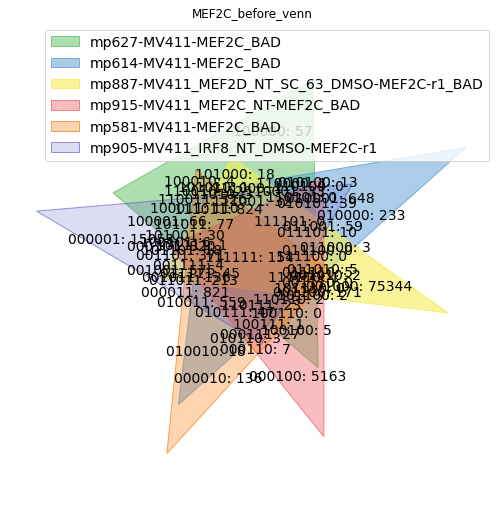

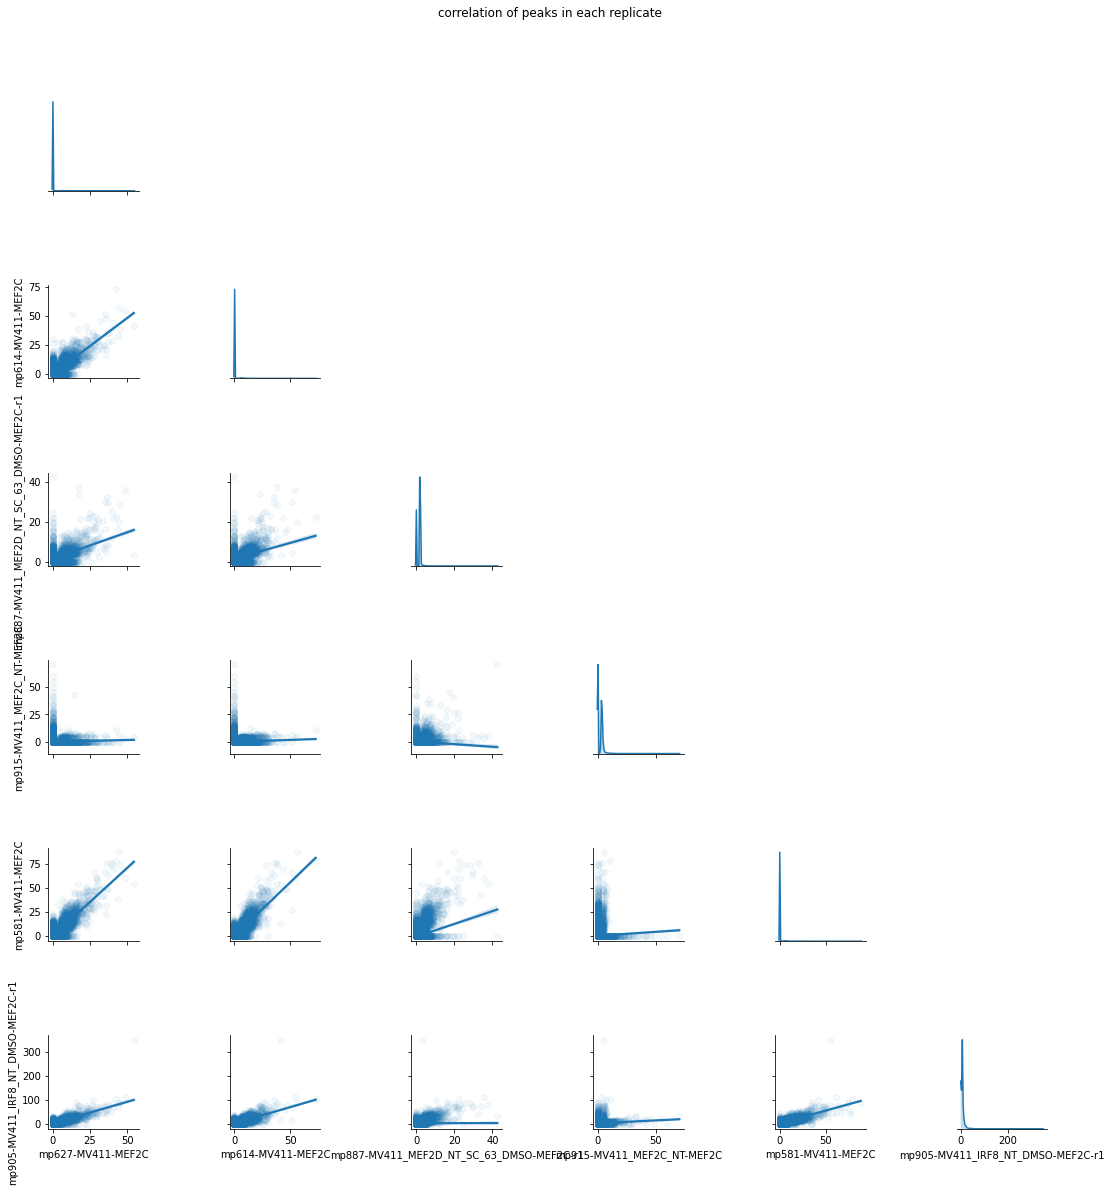

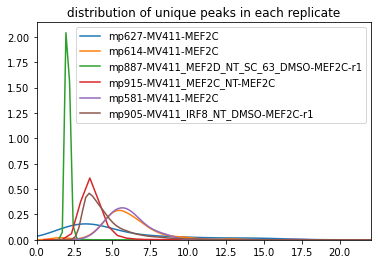

-> main rep is: mp905-MV411_IRF8_NT_DMSO-MEF2C-r1
- mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1
  overlap: 12.06455887921242%
 --> not enough overlap
  not using this replicate from the peakmatrix
- mp581-MV411-MEF2C
  overlap: 15.940931465354033%
 --> not enough overlap
  min,max from newly found peaks: (6.055974381948793, 72.70574935646731)
  we did not had enough initial overlap.
 --> enough overlap
  min,max from newly found peaks: (0.4757003609244202, 373.56526520624453)
  we have recovered 7439 peaks, equal to 26.103586216576602% of the peaks in main replicate
  enough from small overlap to advice to merge the peaks
- mp614-MV411-MEF2C
  overlap: 14.255963650132525%
 --> not enough overlap
  min,max from newly found peaks: (6.134014378741286, 75.09572796999112)
  we did not had enough initial overlap.
 --> enough overlap
  we have recovered 7525 peaks, equal to 26.40536177977402% of the peaks in main replicate
  enough from small overlap to advice to merge the peaks
- mp627-MV411-ME

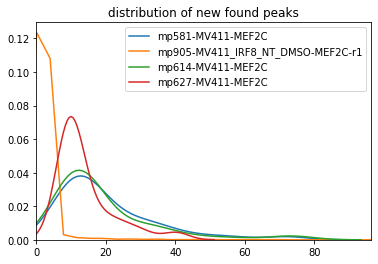

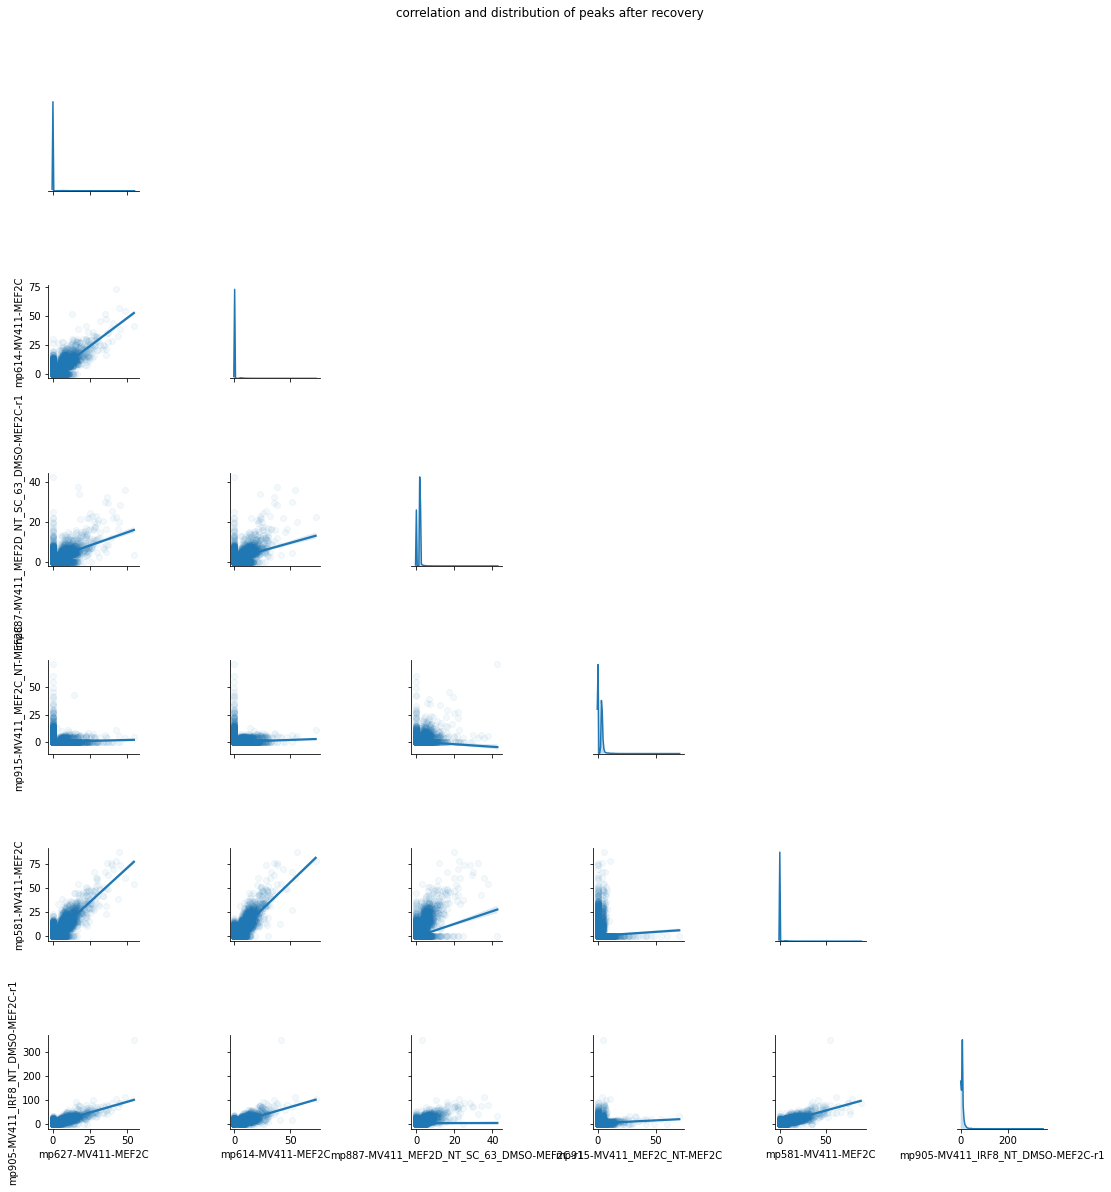

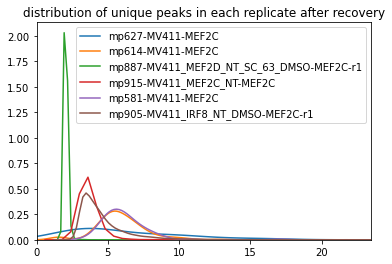

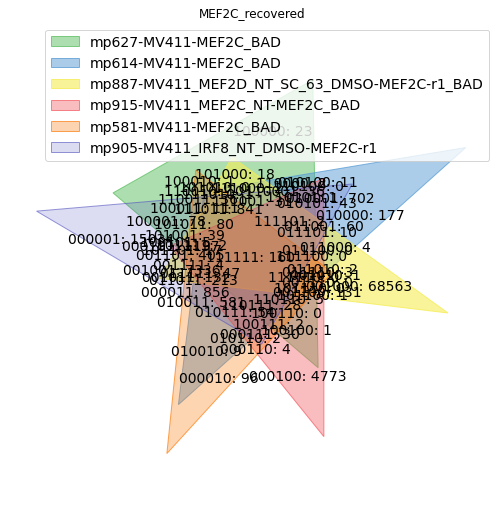

('MEF2C', 28498)


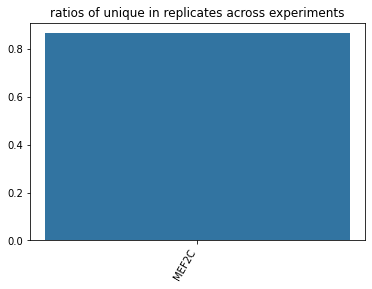

In [816]:
%matplotlib inline
mergedpeak, tomergebam, remove, ratiosofunique = chip.mergeReplicatePeaks(bindings,         '../../data/'+project+'/wigs/bigwig/', markedasbad=bad, window=150, mincov=4, doPlot=True, minKL=10, cov={}, use='poisson', MINOVERLAP=0.25, lookeverywhere=True, only='', saveloc='../results/'+project+'/plots/'+version+'_retryMEF2C/')

In [817]:
mergedpeak #= mergedpeak[mergedpeak.columns[[2,9,3,5,6,4,0,1,7,10]]]

chrom     start       end  peak_number  foldchange  -log10pvalue  \
0      chr1     10087     10317            0    5.914910  1.068010e+01   
1      chr1    180760    181047            1    4.843950  1.076920e+01   
2      chr1    183562    184551            2    3.851040  3.916524e+01   
3      chr1    261731    262752            3    2.155440  3.927820e+00   
4      chr1    605257    605586            4    3.837510  5.112510e+00   
...     ...       ...       ...          ...         ...           ...   
28493  chrY  56715020  56715854       102322   14.657783  1.485973e+05   
28494  chrY  56720710  56721183       102324    3.987447  5.592550e+02   
28495  chrY  56751860  56752350       102327    2.314990  1.082143e+03   
28496  chrY  56763271  56763586       102329    1.970413  2.576388e+06   
28497  chrY  56768533  56770895       102330   14.208765  1.980418e+07   

       -log10qvalue  relative_summit_pos   name     tf  
0      6.748430e+00                  134  MEF2C  MEF2C  
1      6.833590e+00                  134  MEF2C  MEF2C  
2      9.580449e+00                  636  MEF2C  MEF2C  
3      1.561020e+00                 1021  MEF2C  MEF2C  
4      2.433650e+00                  329  MEF2C  MEF2C  
...             ...                  ...    ...    ...  
28493  9.279942e+04                  425  MEF2C  MEF2C  
28494  1.071451e+02                  370  MEF2C  MEF2C  
28495  2.585016e+02                  203  MEF2C  MEF2C  
28496  2.256173e+06                  215  MEF2C  MEF2C  
28497  1.266940e+07                  176  MEF2C  MEF2C  

[28498 rows x 10 columns]

In [740]:
tomergebam

[['mp299-MV411-CEBPA', 'mp72-MV411-CEBPA'],
 ['mp299-MV411-CEBPA', 'mp728-MV411_DMSO-CEBPA'],
 ['mp299-MV411-CEBPA', 'mp112-MV411-CEBPA'],
 ['mp583-MV411-ELF2', 'mp607-MV411-ELF2'],
 ['mp771-MV411-JUND', 'mp772-MV411-JUND'],
 ['mp773-MV411-HOXA9', 'mp774-MV411-HOXA9'],
 ['mp718-MV411-IRF2BP2', 'mp430-MV411-IRF2BP2'],
 ['mp718-MV411-IRF2BP2', 'mp431-MV411-IRF2BP2'],
 ['mp425-MV411-ETV6', 'mp569-MV411-ETV6'],
 ['mp70-MV411-H3K27ac', 'mp702-MV411_DMSO-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp734-MV411_DMSO-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp88-MV411-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp136-MV411-H3K27ac'],
 ['db55-MV411-RUNX1', 'mp300-MV411-RUNX1'],
 ['db55-MV411-RUNX1', 'mp424-MV411-RUNX1'],
 ['db55-MV411-RUNX1', 'mp129-MV411-RUNX1'],
 ['mp767-MV411-FOXP1', 'mp768-MV411-FOXP1'],
 ['mp587-MV411-IKZF1', 'mp604-MV411-IKZF1'],
 ['db46-MV411-BRD4', 'db47-MV411-BRD4'],
 ['mp325-MV411-SP1', 'mp426-MV411-SP1'],
 ['mp325-MV411-SP1', 'mp118-MV411-SP1'],
 ['mp301-MV411-PU1', 'mp428-MV411-PU1'],
 [

In [738]:
# TFs that you might want to remove because of their quality
remove

['WDR5', 'GATA2', 'MEF2C']

## sorting and removing samples

In [739]:
rename = {'FLAG_GFI':'FLAG_GFI1', 'FLAG_PU1':'FLAG_SPI1', 'PU1':'SPI1', 'ZFP281':'ZNF281', 'TFP4':'TFAP4','SREBP1':'SREBF1'}
mergedpeak.tf = mergedpeak.tf.replace(rename)

In [742]:
#what tfs do we have in our set?
tfs = set(mergedpeak.tf)
tfs

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPB',
 'CTCF',
 'E2F3',
 'ELF2',
 'ETV6',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FLI1',
 'FOSL2',
 'FOXP1',
 'GATA2',
 'GFI1',
 'GSE1',
 'H3K18',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'JUND',
 'LDB1',
 'LMO2',
 'LYL1',
 'MAX',
 'MED1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYC',
 'PLAGL2',
 'POLII',
 'PSER2',
 'RARA',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SMC1',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'WDR5',
 'ZEB2',
 'ZMYND8',
 'ZNF281'}

In [741]:
mergedpeak.to_csv('../results/'+project+'/large/merged_replicates_'+version+'.csv.gz')

In [ ]:
bigwigs=os.listdir('../../data/bigwig/')
for val in bigwigs:
    for v in remove + toremove + ['scale','POLII','IGG','CTCF','INPUT']:
        if v in val:
            bigwigs.remove(val)
            break
bigwigs = ['data/bigwig/'+ i for i in bigwigs]

## Consensus set

In [970]:
window = 5
merging_version = "simpleMerge"

In [921]:
#getting the crcs
crc = helper.fileToList('../data/CRCs.csv')
set(crc) - tfs ,tfs - set(crc)
crc = set(crc) & tfs

{'CEBPA',
 'E2F3',
 'ETV6',
 'FLI1',
 'FOSL2',
 'GATA2',
 'GFI1',
 'HOXA9',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZMYND8',
 'ZNF281'}

In [971]:
#merging all the crc to create the cobinding matrix. keeping he flag versions 
keep = ['FLAG_MEF2D','FLAG_GFI1']
remove = ['MEF2D','GFI1','FLAG_IRF2BP2','FLAG_MEF2C','FLAG_SPI1','H3K18','GSE1','HEX']
mergedpeak['name'] = mergedpeak.tf
merged = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin((set(crc)|set(keep))-set(remove))], window=int(window))
crc = (set(crc)|set(keep))-set(remove)

0.0009103113529966478

0.0012770872864855884

In [972]:
window=str(window)
len(merged),len(mergedpeak)

(345181, 3258735)

In [973]:
# the cobinding matrix (saving it as well)
merged

chrom     start       end  peak_number  foldchange   -log10pvalue  \
0       chr1      9936     10317            0    9.946779   31242.919925   
1       chr1     15524     15801            1    3.326400       9.112810   
2       chr1     29182     29649            2   15.734000      43.992500   
3       chr1    180636    182055            3    6.566282  106618.940101   
4       chr1    183251    184594            4    4.109167      39.165239   
...      ...       ...       ...          ...         ...            ...   
345176  chrY  56868585  56869023       345176    2.195410      35.887260   
345177  chrY  56873688  56873928       345177    2.285240       3.414660   
345178  chrY  56875662  56876207       345178    1.826950       4.469960   
345179  chrY  56876514  56876695       345179    4.822720       7.796570   
345180  chrY  56878404  56878890       345180    2.280840       4.686650   

        -log10qvalue  relative_summit_pos  CEBPA  HOXA9  ...     TFAP4  \
0       20942.926956                  107    0.0    0.0  ...  20.13070   
1           7.086980                  277    0.0    0.0  ...   0.00000   
2          40.043900                  145    0.0    0.0  ...   0.00000   
3       24609.011579                  144    0.0    0.0  ...   6.51873   
4          10.775800                  318    0.0    0.0  ...   6.23222   
...              ...                  ...    ...    ...  ...       ...   
345176      8.853066                   65    0.0    0.0  ...   0.00000   
345177      1.359790                  240    0.0    0.0  ...   0.00000   
345178      2.575570                  545    0.0    0.0  ...   0.00000   
345179      5.376070                   56    0.0    0.0  ...   0.00000   
345180      2.371350                  486    0.0    0.0  ...   0.00000   

           RUNX2  MAX     IRF8  MYB  ZEB2     RXRA  SPI1    MEF2C  FLAG_MEF2D  
0       5.750405  0.0  0.00000  0.0   0.0  8.51315   0.0  5.91491     3.86739  
1       0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  0.00000     0.00000  
2       0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  0.00000     0.00000  
3       0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  4.84395     4.68577  
4       0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  3.85104     3.54083  
...          ...  ...      ...  ...   ...      ...   ...      ...         ...  
345176  0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  0.00000     2.19541  
345177  0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  0.00000     0.00000  
345178  0.000000  0.0  0.00000  0.0   0.0  0.00000   0.0  0.00000     0.00000  
345179  0.000000  0.0  4.82272  0.0   0.0  0.00000   0.0  0.00000     0.00000  
345180  0.000000  0.0  2.28084  0.0   0.0  0.00000   0.0  0.00000     0.00000  

[345181 rows x 37 columns]

In [974]:
merged.to_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'.bed.gz', sep='\t',index=None)

In [819]:
merged = pd.read_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'.bed.gz', sep='\t')

## Plotting similarity kernels over TF binding profiles

select a set of TFs to compare

In [533]:
cols = 8
#cols = merged.columns[cols]

In [ ]:
fig = sns.pairplot(merged[cols], corner=True, diag_kind="kde", kind="reg", plot_kws ={"scatter_kws":{"alpha":.05}})
def col_nan_scatter(x,y, **kwargs):
    df = pd.DataFrame({'x':x[:],'y':y[:]})
    df = df[df.sum(0)!=0]
    x = df['x']
    y = df['y']
    plt.gca()
    plt.scatter(x,y)
def col_nan_kde_histo(x, **kwargs):
    df = pd.DataFrame({'x':x[:]})
    df = df[df['x']!=0]
    x = df['x']
    plt.gca()
    sns.kdeplot(x)
fig = fig.map_upper(col_nan_scatter)
fig = fig.map_upper(col_nan_kde_histo)
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_pairplot_experiments.pdf')
plt.show()
counts,val = np.unique(merged[merged.columns[cols:]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'pairplot_experiments.pdf')
plt.show()
i = merged[merged.columns[cols:]].astype(bool).sum(1)
print(i.max(),i.mean(),i.min())

## The cobinding Matrix

In [975]:
merging_version = "remove_single"

In [976]:
#merged = merged.drop(columns='PU1_FLAG')
merged = merged[merged[merged.columns[cols:]].astype(bool).sum(1)>1].reset_index(drop=True)

In [977]:
merged[merged.columns[:cols]].to_csv('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_conscensus.bed.gz',sep='\t',index=None, columns=None)

### correlations over cobindings

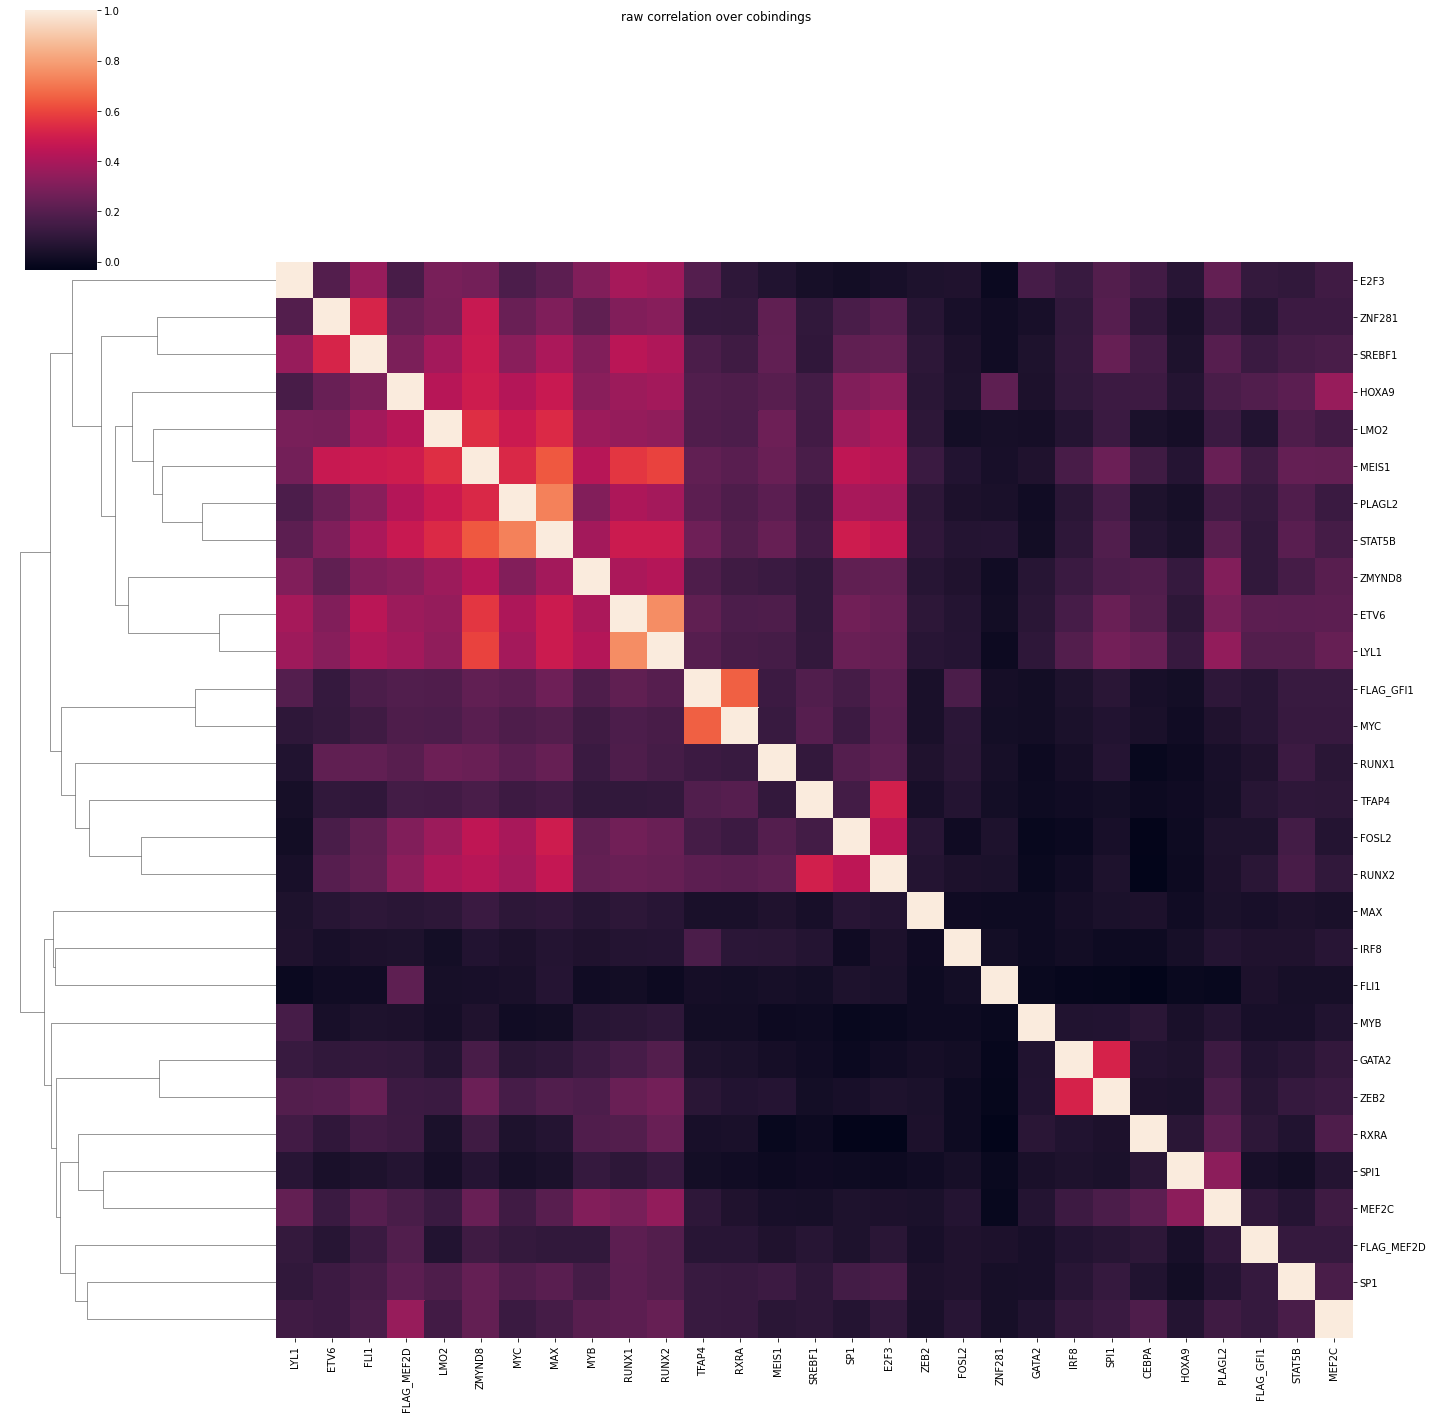

In [978]:
#raw correlation over cobindings
fig = sns.clustermap(np.corrcoef(stats.zscore(merged[set(merged.columns[cols:])].values.T, axis=1)), figsize=(20, 20), xticklabels=merged.columns[cols:], yticklabels=set(merged.columns[cols:])-set(['CEBPA']))
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("raw correlation over cobindings")
fig.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_correlation_cobinding_regular.pdf")

In [769]:
#for plotting the cobinding we are only looking at a random subset (~0.3%)
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

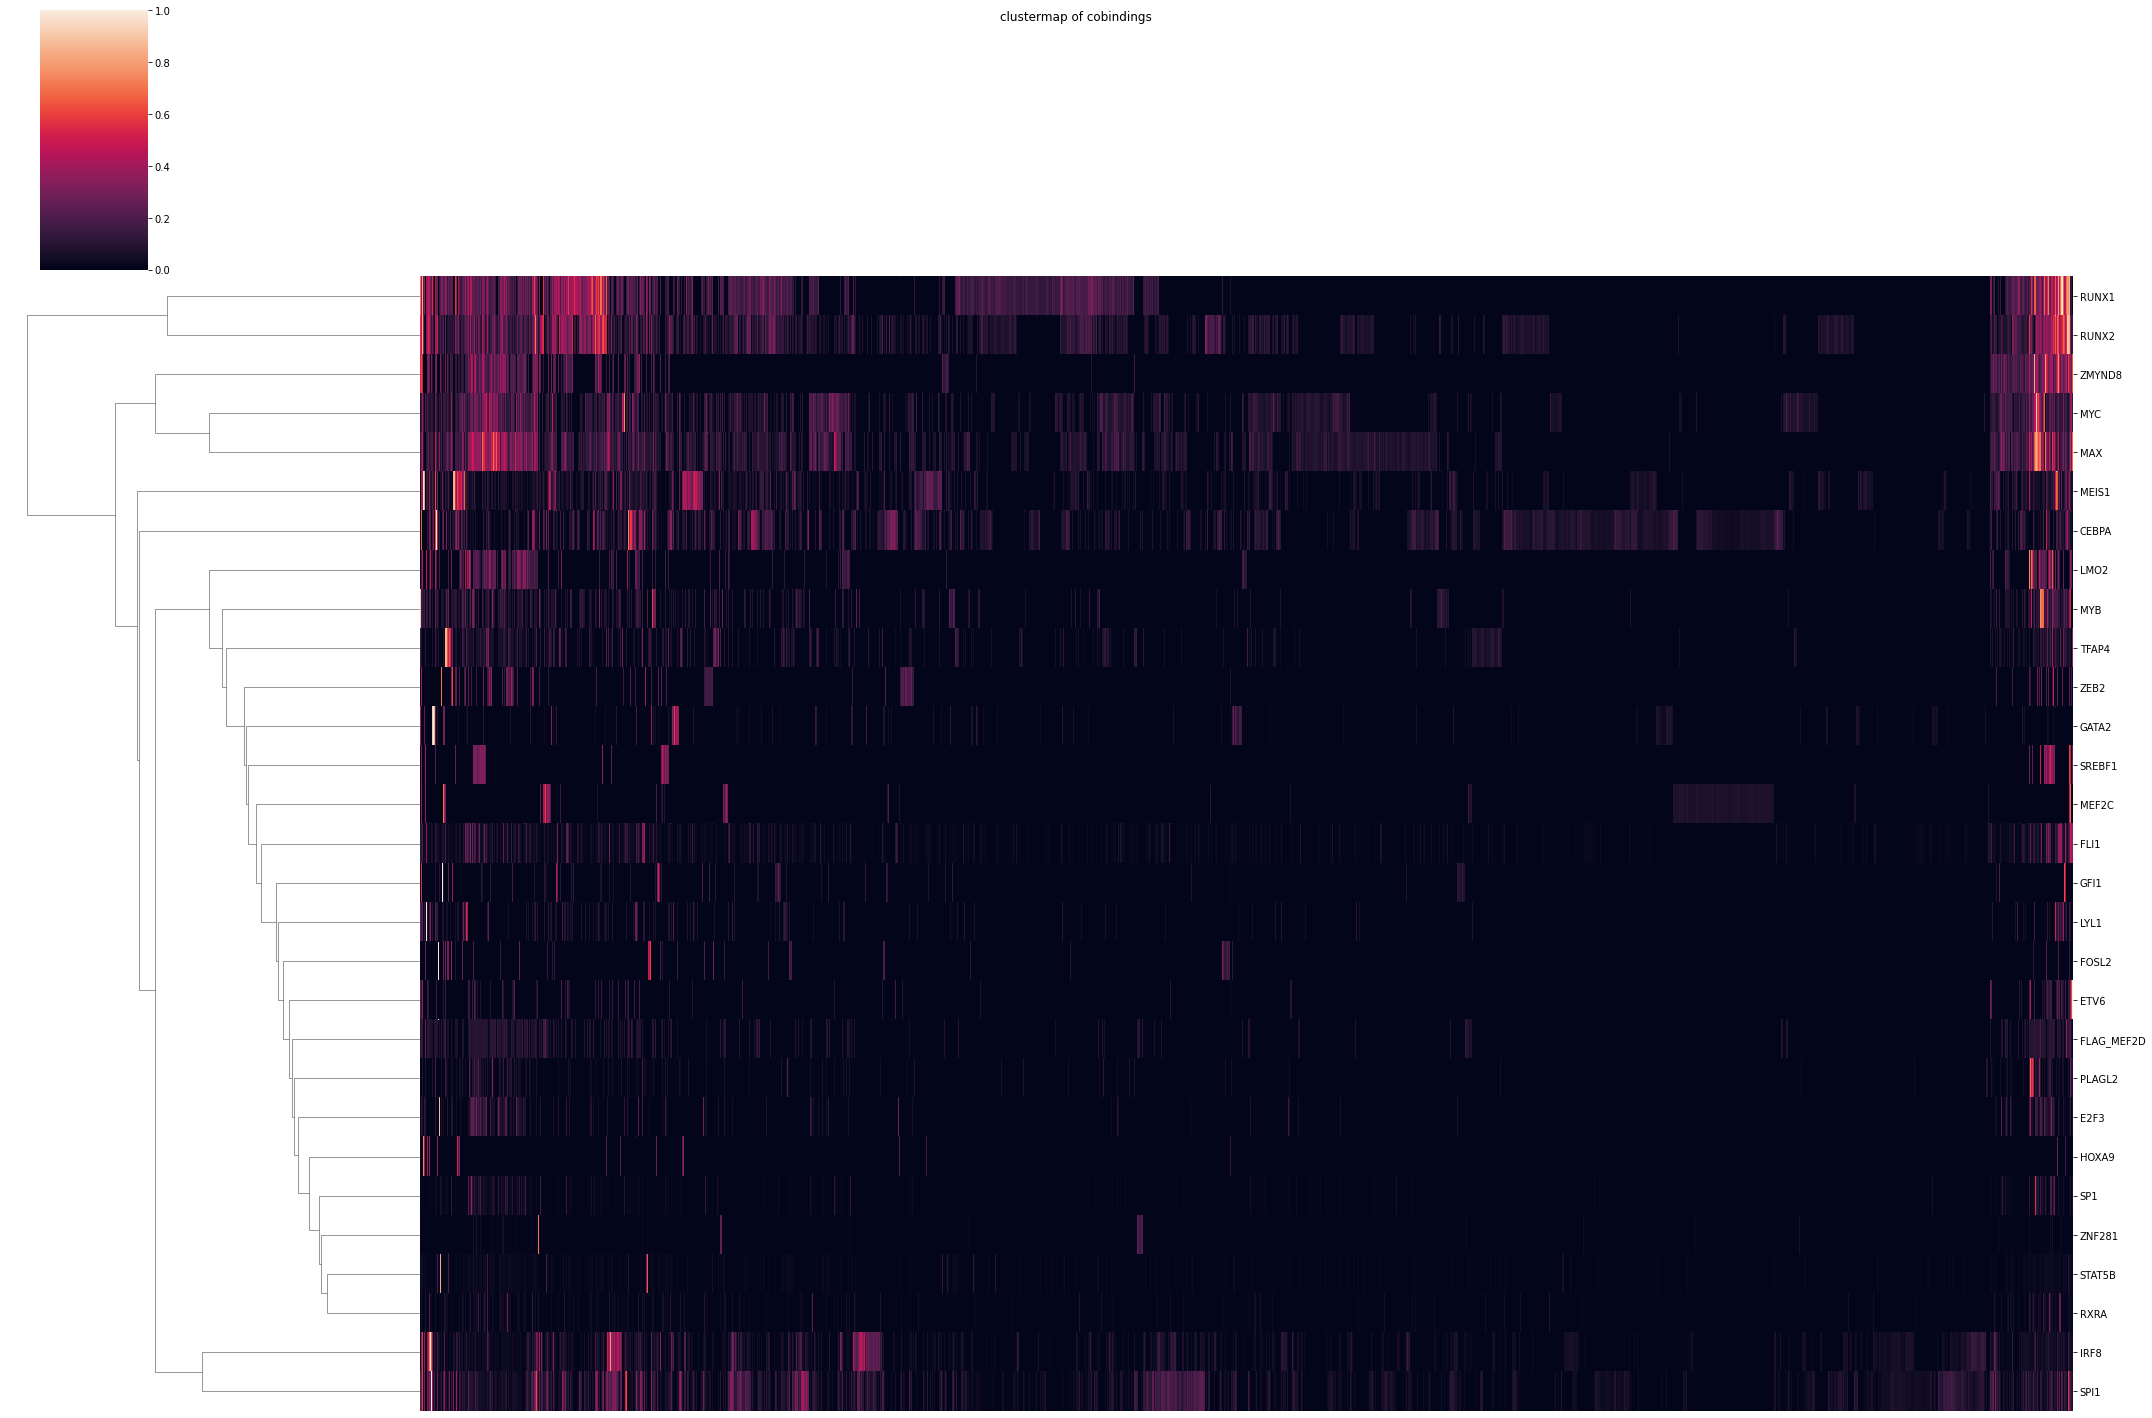

In [770]:
#clustermap of cobindings
fig = sns.clustermap(merged[merged.columns[cols:]].loc[rand].T, standard_scale=0, figsize=(30,20),xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled.pdf')
plt.show()

## Peak annotations

In [771]:
#list of additional chips not directly used in our cobinding matrix (used for annotations)
set(mergedpeak.tf) - set(merged.columns) 

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPB',
 'CTCF',
 'ELF2',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_SPI1',
 'FOXP1',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'IKZF1',
 'IRF2BP2',
 'JUND',
 'LDB1',
 'MED1',
 'MEF2D',
 'MLL_KTM2A',
 'MYBL2',
 'POLII',
 'PSER2',
 'RARA',
 'SMC1',
 'WDR5'}

In [772]:
additional = {}
# creating activation and repression histone signal
additional['activation'] = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(["H3K27ac",'H3K79me2','H3K36me3','H3K4me3','H3K9ac','H3K4me1'])], window=10, mergedFold="max")
additional['repression'] = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(['H3K27me3', 'H3K36me2'])], window=10, mergedFold="max")
# adding other additionals
for val in set(mergedpeak.tf) - (set(merged.columns) | set(remove)):
    # let's as well only use the flag version of IRF2BP2
    if val in drop: 
        continue
    additional[val] = mergedpeak[mergedpeak.tf==val]

0.0063075362189099265

0.009412813511779538

0.021541112752338748

0.04294234814914283

0.04771123345717142

0.054863628903510736

0.06114691971412799

0.06717283619056146

0.07048886203243662

0.07406785730271698

0.07742491383554899

0.07866888978410397

0.08027095176282768

0.08674447577697209

0.1193974456529848

0.13091960968622712

0.1324545305342942

0.1414141414141414

0.15589984035331156

### compute promoters

In [857]:
promoters = pd.read_csv('../data/'+project+'/compute_genes/human_epdnew_TeLy2.bed', sep='\t',header=None).rename(columns={0:'chrom',1:'start',2:'end',3:'name',5:'strand'}).drop(4,1)
promoters['foldchange']=1
promoters['name']=[i[:-2] for i in promoters['name']]
additional['promoters'] = promoters

### adding super enhancers

In [663]:
peaks = !ls ../../data/$project/MV411peak/*H3K27ac*
peaks

['../../data/Cobinding_ChIP/MV411peak/mp136-MV411-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp183-MV411_DMSO-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp702-MV411_DMSO-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp70-MV411-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp734-MV411_DMSO-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp88-MV411-H3K27ac_R1_peaks.broadPeak']

In [120]:
# we need to load all H3K27ac's bam files
! mkdir ../../data/$project/bams/
! gsutil -m cp gs://amlproject/Chip/res/bwa/mergedLibrary/*MV411*H3K27ac* ../../data/$project/bams/
! gsutil cp gs://amlproject/Chip/res/bwa/mergedLibrary/mp99* ../../data/$project/bams/
bams = ! ls ../../data/$project/bams/*MV411*.bam
bais = ! ls ../../data/$project/bams/*MV411*.bai

Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp70-MV411-H3K27ac_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp70-MV411-H3K27ac_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp734-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/mp734-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam

In [164]:
#calling ROSE
helper.createFoldersFor('../../data/'+project+'/ROSE/')
for i, peak in enumerate(peaks):
    if i < 2:
        continue
    chip.MakeSuperEnhancers(peak,
                             bamFile=bams[i],
                             baiFile=bais[i],
                             controlBam= bams[-1],
                             controlBai= bais[-1],
                             outdir ='../../../data/'+project+'/ROSE/',
                             rosePath="../src/ROSE/") #no cd -

we are going to move your input files to ../src/ROSE/
finished.. moving them back to their original folder
worked
CompletedProcess(args='mv ../src/ROSE/mp702-MV411_DMSO-H3K27ac_R1_peaks.broadPeak.bed ../../data/Cobinding_ChIP/MV411peak/mp702-MV411_DMSO-H3K27ac_R1_peaks.broadPeak && mv ../src/ROSE/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam ../../data/Cobinding_ChIP/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam && mv ../src/ROSE/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai ../../data/Cobinding_ChIP/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai && mv ../src/ROSE/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam ../../data/Cobinding_ChIP/bams/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam && mv ../src/ROSE/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam.bai ../../data/Cobinding_ChIP/bams/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam.bai', returncode=0, stdout=b'', stderr=b'')
we are going to move your input files to ../src/ROSE/
finished.. moving them back to their original folder
worked
CompletedP

In [680]:
#merging them all as well into one superenhancer set
rose = chip.simpleMergePeaks(chip.ReadRoseSuperEnhancers("../../data/"+project+"/ROSE/"), window=1000).drop(columns=["relative_summit_pos","-log10pvalue","-log10qvalue"])
# we get only enhacers supported by at least 1/3rd of our chips (>1)
rose = rose[rose[rose.columns[5:]].astype(bool).sum(1)>1]
additional['super_enhancer'] = rose.sort_values(by =['chrom', 
                                                     'start', 'end']).reset_index(drop = True)

0.24612464409996837

0.6414109459031951

0.8785194558683961

### adding ATACseq datta

In [551]:
! gsutil cp gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_*.broadPeak ../../data/$project/MV411peak/

Copying gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_MV411.mRp.clN_peaks.broadPeak...
/ [1 files][ 10.5 MiB/ 10.5 MiB]                                                
Operation completed over 1 objects/10.5 MiB.                                     


In [664]:
atac = !ls ../../data/$project/MV411peak/ATAC_*
for i,v in enumerate(atac):
    a = chip.loadPeaks(v, isMacs=False)
    a = a[['chrom','start',"end","peak_number",'foldchange']]
    a['strand'] = '+'
    additional['ATAC' if len(atac)==1 else 'ATAC'+str(i)] = a 
    #TODO: merge multiple atacseqs
#creating a folder to save all marks for cchromHMM
helper.createFoldersFor("../results/"+project+"/"+version+'_'+merging_version+'_'+window+"_MV411Merged/")
a.to_csv('../results/'+project+"/"+version+'_'+merging_version+'_'+window+'_MV411Merged/ATAC.bed',index=False,sep='\t')

In [553]:
# saving all marks
for i in set(mergedpeak.tf):
    a = mergedpeak[mergedpeak.tf==i][['chrom','start',"end",'peak_number',"foldchange"]]
    a['strand']='+'
    a.to_csv("../results/" + project + "/" + version + '_' + merging_version + '_' + window + "_MV411Merged/" + i + '.bed', sep='\t', index=False)

### Running and adding ChromHMM

In [554]:
#list of interesting marks for ChromHMM
l = ["H3K27ac", "H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"]

In [563]:
## computing CHROMHMM
#!mkdir ../results/chromHMM/
outdir = '../results/chromHMM/' + version + '_' + merging_version + '_' + window + '_2/'
data = pd.DataFrame([['MV411'] * len(l), l,["../results/" + project + "/" + version + '_' + merging_version + '_' + window + '_MV411Merged/' + i + '.bed' for i in l]]).T

chrombed = chip.runChromHMM(outdir, data, numstates=15, datatype = 'bed', chromHMMFolderpath="../src/ChromHMM/", control_bam_dir = None)['MV411']

you need to have ChromHMM
CompletedProcess(args='java -mx8000M -jar ../src/ChromHMM/ChromHMM.jar BinarizeBed ../src/ChromHMM/CHROMSIZES/hg38.txt . ../results/chromHMM/v3_simpleMerge_150_2/input_data.tsv ../results/chromHMM/v3_simpleMerge_150_2/binarized', returncode=0, stdout=b'Writing to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr1_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr2_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr3_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr4_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr5_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr6_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chr7_binary.txt\nWriting to file ../results/chromHMM/v3_simpleMerge_150_2/binarized/MV411_chrX_binary.txt\nW

CompletedProcess(args='java -mx8000M -jar ../src/ChromHMM/ChromHMM.jar LearnModel -printposterior -noautoopen -init load -m ../src/ChromHMM/model_15_coreMarks.txt ../results/chromHMM/v3_simpleMerge_150_2/binarized ../results/chromHMM/v3_simpleMerge_150_2/ 15 hg38', returncode=1, stdout=b'', stderr=b'Exception in thread "main" java.lang.IllegalArgumentException: For mark 0 in model file found H3K27me3, but expecting H3K27ac. This might be because columns of binarized file are in a different order from model learning.\n\tat edu.mit.compbio.ChromHMM.ChromHMM.loadModelSmooth(ChromHMM.java:3001)\n\tat edu.mit.compbio.ChromHMM.ChromHMM.buildModel(ChromHMM.java:1020)\n\tat edu.mit.compbio.ChromHMM.ChromHMM.main(ChromHMM.java:14443)\n')


ValueError: b'Exception in thread "main" java.lang.IllegalArgumentException: For mark 0 in model file found H3K27me3, but expecting H3K27ac. This might be because columns of binarized file are in a different order from model learning.\n\tat edu.mit.compbio.ChromHMM.ChromHMM.loadModelSmooth(ChromHMM.java:3001)\n\tat edu.mit.compbio.ChromHMM.ChromHMM.buildModel(ChromHMM.java:1020)\n\tat edu.mit.compbio.ChromHMM.ChromHMM.main(ChromHMM.java:14443)\n'

In [ ]:
# state information
from IPython.display import Image, display
im = ! ls $out*.png
for val in im:
    display(Image(filename=val))

In [ ]:
#setting state colors for plots
statetocol={i: chrombed[chrombed['state']==i].iloc[0]['color'] for i in set(chrombed['state'])}
statetocol.update({0:'0,0,0'})
for i,v in statetocol.items():
    statetocol[i] = tuple([int(i)/256 for i in v.split(',')])

In [665]:
#renaming the states (and some other marks)
rn = {'SMC1':'cohesin', 'MED1':'mediator', 'ATAC':'open regions','state_1':'acti_state', 'state_2':'elong_state', 'state_5':'start_state', 'state_6':'repres_state'}
annot = len(merged.columns)
annot

37

### merging 
merging everything from additionals into the cobinding matrix

In [802]:
merged.columns[:annot+1]

Index(['chrom', 'start', 'end', 'peak_number', 'foldchange', '-log10pvalue',
       '-log10qvalue', 'relative_summit_pos', 'CEBPA', 'HOXA9', 'PLAGL2',
       'MEIS1', 'ETV6', 'GFI1', 'RUNX1', 'FOSL2', 'FLI1', 'GATA2', 'SP1',
       'E2F3', 'ZNF281', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'LYL1', 'MYC',
       'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'SPI1', 'MEF2C',
       'FLAG_MEF2D', 'activation'],
      dtype='object')

In [854]:
#chrombed['foldchange']= chrombed['state']
#merged['HMM_states'] = chip.putInBed(merged[merged.columns[:cols]], chrombed, window=1, mergetype='first')
for key, val in additional.items():
    if key in merged.columns:
        continue
    print(key)
    if len(val)>1 and key not in ['FLAG_MEF2C']:
        merged[key] = chip.putInBed(merged[merged.columns[:cols]],val)
merged = merged.replace(np.nan,0)

activation
103110 were merged into conscensus
repression
45383 were merged into conscensus
ELF2
39088 were merged into conscensus
JUND
3206 were merged into conscensus
FLAG_SPI1
94422 were merged into conscensus
FLAG_IRF2BP2
17422 were merged into conscensus
SMC1
51680 were merged into conscensus
LDB1
26379 were merged into conscensus
WDR5
65294 were merged into conscensus
H3K27me3
4294 were merged into conscensus
MYBL2
336 were merged into conscensus
CDK9
50181 were merged into conscensus
H3K4me3
24383 were merged into conscensus
FOXP1
44338 were merged into conscensus
MLL_KTM2A
41340 were merged into conscensus
RARA
5182 were merged into conscensus
IKZF1
31101 were merged into conscensus
AFF4
3562 were merged into conscensus
CTCF
17051 were merged into conscensus
BRD4
47587 were merged into conscensus
CEBPB
90604 were merged into conscensus
H3K36me2
41884 were merged into conscensus
PSER2
25781 were merged into conscensus
FLAG_MEF2C
1932 were merged into conscensus
H3K36me3
10136 wer

#### total size of the cobinding matrix on the DNA

In [860]:
sum([v['end'] - v["start"] for k, v in merged.iterrows()])

94143114

In [855]:
## making regular enhancers from otherr annotations
merged['regular_enhancer'] = (merged['activation'].astype(bool) & ~merged['super_enhancer'].astype(bool) & ~merged['promoters'].astype(bool)).astype(float)

KeyError: 'promoters'

In [308]:
#setting each state as a separate annotation
for i in range(1,1+numstates):
    merged['state_'+str(i)] = (merged.HMM_states==i).astype(float)
merged = merged.drop(columns=['HMM_states'])
# renaming
merged = merged.rename(columns=rn)

In [867]:
merged = merged.drop(columns="FLAG_MEF2C")

In [984]:
merging_version="remove_single"
window="150"
version

'v3'

In [926]:
merged = merged[merged[merged.columns[cols:]].astype(bool).sum(1)>1].reset_index(drop=True)

In [927]:
merged.to_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'_with_annotations.bed.gz', sep='\t',index=None)

In [985]:
merged = pd.read_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'_with_annotations.bed.gz', sep='\t')

## In depth look at the cobinding matrix

First looking at the Basic Information about each annotations: total number of peaks, max peak signel, mean peak signal, stdev of peak signals

In [928]:
# Showing Basic Information about each annotations
info = pd.concat([merged[merged.columns[cols:]].astype(bool).sum(0),
           merged[merged.columns[cols:]].max(),
           merged[merged.columns[cols:]].replace(0, np.NaN).mean(),
          merged[merged.columns[cols:]].replace(0, np.NaN).var()],axis=1).rename(columns={0:'sum',1:'max',2:'mean',3:'std'})
info.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'info.tsv')
info.iloc[:60]

sum          max       mean          std
CEBPA         56524   123.662740  10.371736    60.990329
HOXA9          1264    36.844650   7.179492    11.735557
PLAGL2        13978  1424.570000   8.478562   277.488796
MEIS1         51650    99.050100  10.121474   101.924229
ETV6           6671    80.067433   9.824713    41.801551
FLAG_GFI1     22234    82.751400   5.985914    30.929234
RUNX1         51965    85.437050   8.414745    24.435953
FOSL2          4109   367.017000  10.657884   127.103514
FLI1          52978   512.890000  16.315432   442.142200
GATA2         10475   191.227000  17.097017   390.289926
SP1           24126   684.427000  14.856561   414.141787
E2F3          14916   598.145000  11.189661   145.311047
ZNF281        16694  3947.190000  21.532453  7005.143887
SREBF1         4153   645.240000   7.150709   173.473396
LMO2          15365    43.670685   6.623872    11.151959
STAT5B        28950   293.239000   6.149333   107.926145
ZMYND8        21677    45.176050   7.411960    12.587723
LYL1          11810    89.225000   8.952361    54.522130
MYC           58860    83.149145   5.712393    16.860874
TFAP4         27208  1356.100000   8.832087   178.543959
RUNX2         71214    75.824667   9.623176    62.596968
MAX           68593   110.474250  10.234019    62.384880
IRF8          55518   259.973103  11.331605   175.485455
MYB           24565   125.953500   8.429188    49.776719
ZEB2           8049   812.188933   7.417450   237.677871
RXRA          14205  1240.170000   7.340065   169.826706
SPI1          73329   200.846033  14.725140   152.383603
MEF2C         19413    84.652118   5.479833    11.248523
FLAG_MEF2D    22536   133.333967   4.339931     5.421075
activation    85159    29.194000   5.703074    22.104275
repression    39035    17.297600   3.966243     1.762259
ELF2          34737   114.326900  11.612419    89.558995
JUND           3162    63.074500   5.608475     5.345258
FLAG_SPI1     82307    64.507200  15.664357   154.191219
FLAG_IRF2BP2  16175    30.638700   4.817519     3.452585
SMC1          40466    86.709700   9.918947    80.236983
LDB1             88    30.134700   9.134165    22.653049
H3K79me2      23703    16.227400   5.375271     6.073717
WDR5            567    42.445660   9.312672    52.147726
H3K27ac       55607    18.188992   4.475424     3.721401
H3K27me3       3952    16.938800   3.968827     1.110934
MYBL2           307    35.384400   8.556340    19.602319
CDK9          45893    65.188600   5.592977     8.097747
H3K4me3       23976    29.194000  11.895385    34.070968
FOXP1         42321    78.395000   6.836584    17.231268
MLL_KTM2A     33016    17.241300   4.818653     1.330141
RARA           5109   343.553000   8.061526    80.096205
IKZF1         28271    75.841100   6.871603    12.785701
AFF4           3133    96.589900   5.648706    14.856113
CTCF          16360    77.679100  19.215044   126.866555
BRD4          44231    13.187515   3.928123     1.002454
CEBPB         53787   150.145000   9.429518    90.243406
H3K36me2      36006    17.297600   3.947916     1.825128
PSER2         23665    59.964700   7.823842    50.823717
H3K36me3       9440    14.576100   3.630248     1.103536
H3K9ac        41113    20.637600   5.751187    11.299245
CDK13            88    75.114900   7.155730    73.542508
H3K4me1       46853     5.403210   2.998511     0.128665
POLII         32181    94.570360   4.176736    10.533573
MED1          35716    29.567060   3.877880     1.550205

In [929]:
info.iloc[60:]

sum        max      mean        std
super_enhancer   9571  36.169492  6.172187  12.823486
promoters       10123   1.000000  1.000000   0.000000

In [870]:
touse = ['activation', 'repression', 'FLAG_IRF2BP2', 'cohesin', 'H3K79me2', 'H3K27me3', 'H3K27ac','H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA', 'IKZF1','H3K18', 'H3K36me2', 'H3K36me3', 'H3K9ac', 'H3K4me1', 'POLII', 'mediator', 'open regions', 'promoters', 'super_enhancer', 'regular_enhancer']

In [930]:
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

data = merged[merged.columns[annot:]]
ma = data.max()
mi = data.min()
data = data.loc[rand]
data = (data-mi)/(ma-mi)
for val in data.columns:
    a = [viridis(int(v*256)) for v in data[val]]
    data[val] = a

### cobinding matrix

A matrix computed from overlapping binding profiles of TFs composing the CRC (bottom / red color). any peak around  window of X (150bp) to another get merged into a single, longer peak that has both TFs. Under this new set of peaks, we are looking for peaks from other proteins and histone marks (top / blue colors). This new addition won't change the matrix itself.

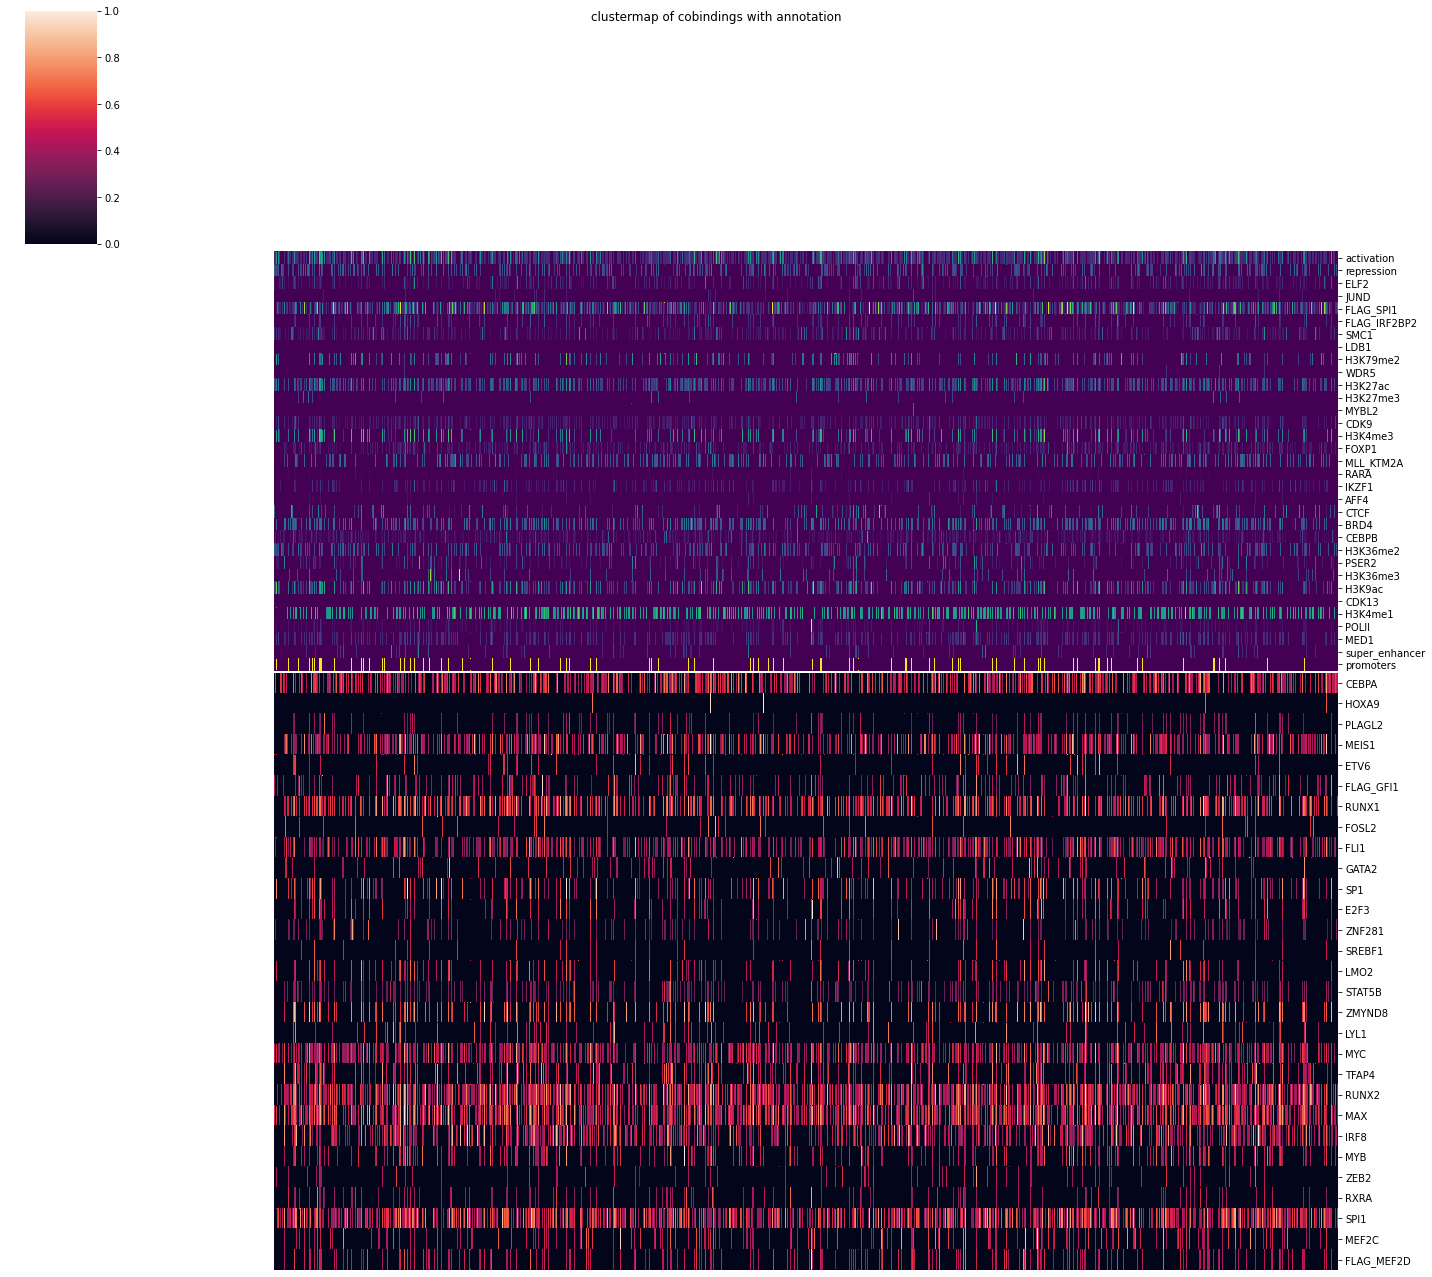

In [931]:
#clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[cols:annot]].loc[rand].T), standard_scale=0, colors_ratio=0.01, figsize=(20,18), col_colors = data, xticklabels=False, row_cluster=False, col_cluster=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings with annotation")

fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled_full_annotations.pdf')
plt.show()

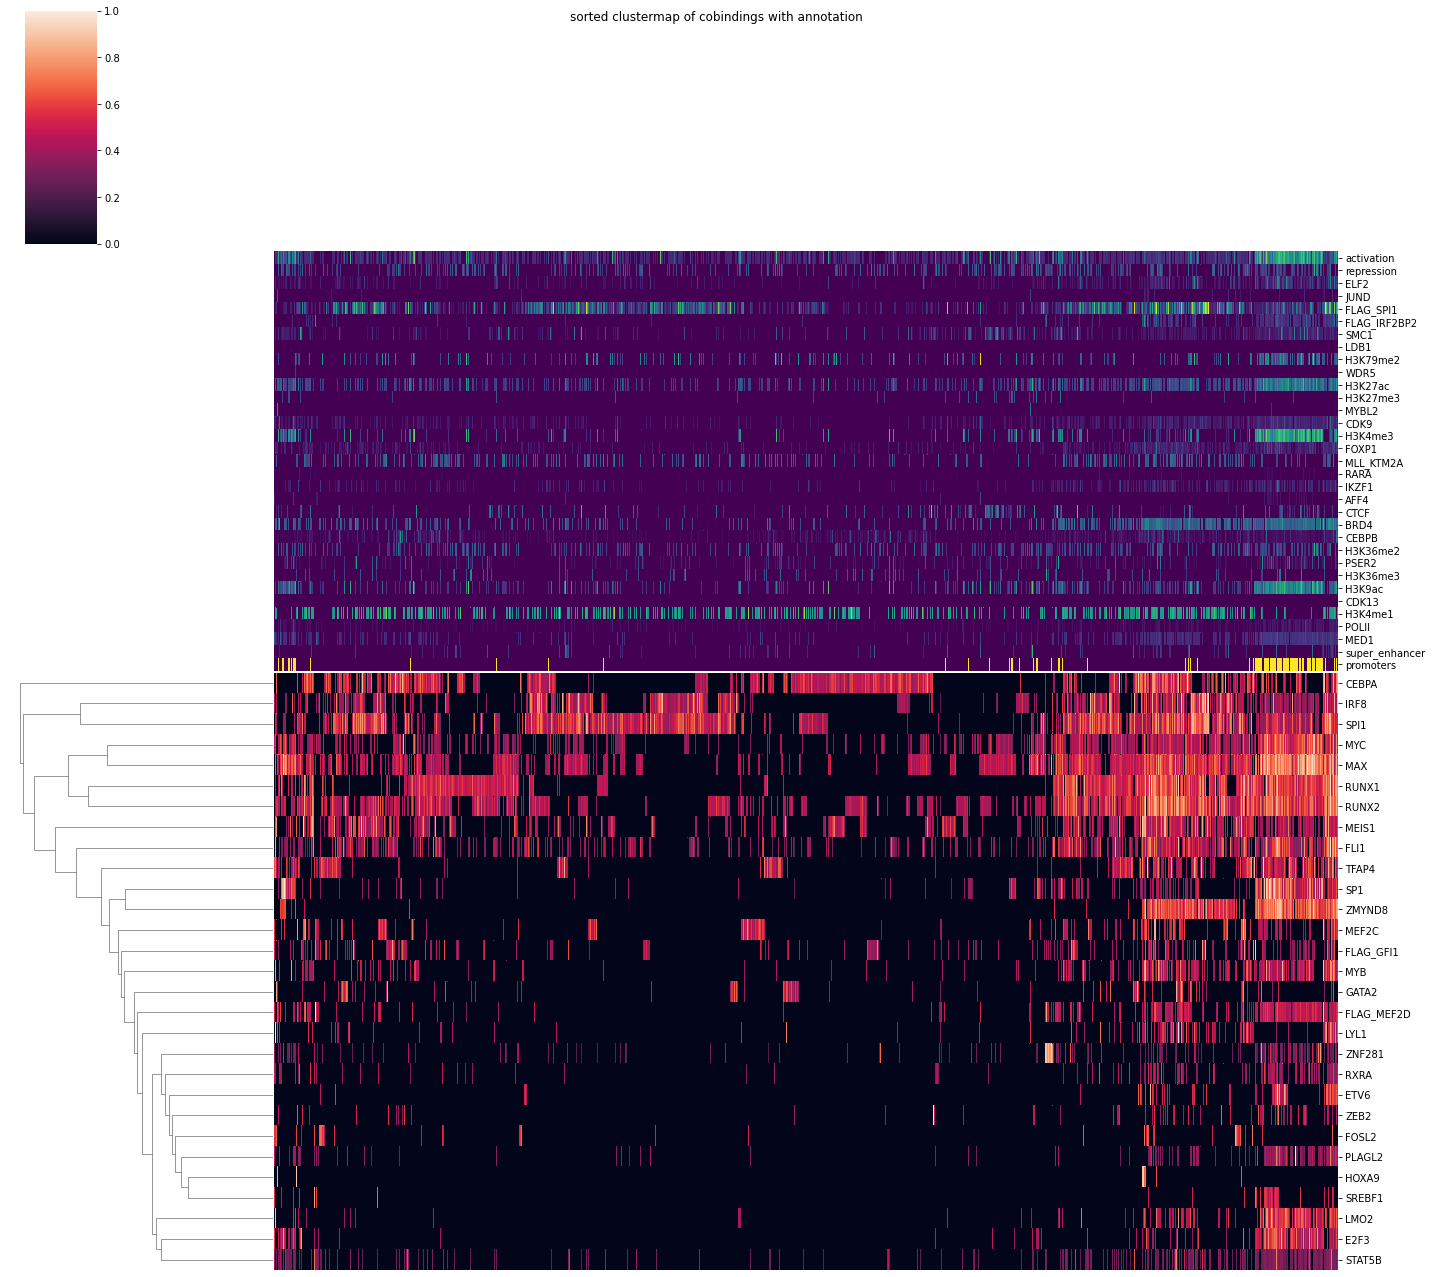

In [932]:
#sorted clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[cols:annot]].loc[rand].T), vmin=0, vmax=1, figsize=(20,18), colors_ratio=0.01, standard_scale=0, col_colors=data, xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("sorted clustermap of cobindings with annotation")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled_full_annotation_sorted.pdf')
plt.show()

### TSNE of CRC binding profile

A 2D plot showing the similarity of different transcription factors. Plot using TSNE where similarity is represented by local distances. the similarity is computed on peak signal for each TF across the cobinding matrix. 

In [980]:
#scatter plot of distance of TF in cobinding space
red = TSNE(2,3).fit_transform(PCA(10).fit_transform(stats.zscore(merged[merged.columns[cols:annot]]).T))
pd.DataFrame(index=merged.columns[cols:annot],data=red, columns=['x','y']).to_csv("../results/"+project+'/'+version+"_"+window+"_"+merging_version+"_tsne_coordinates_crc_only.csv")
plot.scatter(red, radi=10, labels=merged.columns[cols:annot], showlabels=True, title="scatter plot of distance of TF in cobinding space", folder="../results/"+project+'/plots/'+version+"_"+window+"_"+merging_version+"_")

Figure(id='26285', ...)

In [935]:
merged.columns[cols:]

Index(['CEBPA', 'HOXA9', 'PLAGL2', 'MEIS1', 'ETV6', 'FLAG_GFI1', 'RUNX1',
       'FOSL2', 'FLI1', 'GATA2', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2',
       'STAT5B', 'ZMYND8', 'LYL1', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8',
       'MYB', 'ZEB2', 'RXRA', 'SPI1', 'MEF2C', 'FLAG_MEF2D', 'activation',
       'repression', 'ELF2', 'JUND', 'FLAG_SPI1', 'FLAG_IRF2BP2', 'SMC1',
       'LDB1', 'H3K79me2', 'WDR5', 'H3K27ac', 'H3K27me3', 'MYBL2', 'CDK9',
       'H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA', 'IKZF1', 'AFF4', 'CTCF',
       'BRD4', 'CEBPB', 'H3K36me2', 'PSER2', 'H3K36me3', 'H3K9ac', 'CDK13',
       'H3K4me1', 'POLII', 'MED1', 'super_enhancer', 'promoters'],
      dtype='object')

### TSNE of TF binding profile

A 2D plot showing the similarity of different transcription factors. Plot using TSNE where similarity is represented by local distances. the similarity is computed on peak signal for each TF across the cobinding matrix. 

In [990]:
#scatter plot of distance of TF in cobinding space
red = TSNE(2,6).fit_transform(stats.zscore(merged[merged.columns[cols:]]).T)
pd.DataFrame(index=merged.columns[cols:],data=red, columns=['x','y']).to_csv("../results/"+project+'/'+version+"_"+window+"_"+merging_version+"_tsne_coordinates_crc_only.csv")
plot.scatter(red, radi=5, labels=merged.columns[cols:], colors=[1 if val in crc else 0 for val in merged.columns[cols:]], showlabels=True, title="scatter plot of distance of TF in cobinding space", folder="../results/"+project+'/plots/'+version+"_"+window+"_"+merging_version+"_")

Figure(id='30190', ...)

In [938]:
%store merged
%store merging_version

Stored 'merged' (DataFrame)
Stored 'merging_version' (str)


## Comparison to a random distribution 

### computation:

we are evalutating each event's probability 1 binding, 2 binding, n binding.., as a binomial over the amount of proability p_i with n retries corresponding to the size of the conscensus peak set.
the probability p_i of this binomial is the sum of probabilities of having tf a binding with b for all possible combination of tf. 
the number of combination is k amongst n, n being 33, k going from 1 to 29
we compute 

$p(a & b) = p(a)\*p(b) =p(ab)$

and 

$p(a & b) | p(a & c) = p(ab) + p(ac) - p(abc)$

for a,b,c,d:

$p(ab) + p(ac) + p(ad) + p(bc) + p(bd) + p(cd) - {3\choose 2}*(p(abc) - p(abd) - p(bcd) - p(acd)) - {4\choose 2}*p(abcd)$

now we will be making the expected distribution

In [889]:
proba = (merged[merged.columns[cols:annot]].astype(bool).sum(0)/len(merged)).tolist()
size= len(proba)+1
sums = helper.makeCombinations(size, proba)

29
40920
28
237336
27
1107568
26
4272048
25
13884156
24
38567100
23
92561040
22
193536720
21
354817320
20
573166440
19
818809200
18
1037158320
17
1166803110
16
1166803110
15
1037158320
14
818809200
13
573166440
12
354817320
11
193536720
10
92561040
9
38567100
8
13884156
7
4272048
6
1107568
5
237336
4
40920
3
5456
2
528
1
33


In [890]:
# we are saving the expected distributions (as it is long to compute)
version = "v3"
merging_version = "simpleMerge"
window = "150"
a = '../results/' + project + '/*_sums.json'
!ls $a

../results/Cobinding_ChIP/v2_simpleMerge_150_sums.json
../results/Cobinding_ChIP/v3_remove_single_150_sums.json


In [891]:
helper.dictToFile(sums,'../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'_sums.json')

In [26]:
sums = helper.fileToDict('../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'_sums.json')
s={} 
for k,v in sums.items():
    s[int(k)] = sums[k]
sums = s
sums

{1: [39375.860078915546, 34923.44986335529],
 2: [76716.90416390114, 59815.717345763675],
 3: [89118.55996666614, 66311.39074603183],
 4: [69924.20433202894, 55883.46001875424],
 5: [39675.96204361759, 35155.42537353387],
 6: [16985.826924230558, 16157.296513782503],
 7: [5643.449017645179, 5551.990475091973],
 8: [1483.6170522529567, 1477.2961554932504],
 9: [312.79780139758947, 312.5168297824765],
 10: [53.375991275489014, 53.36780988782561],
 11: [7.41462658780752, 7.414468712709706],
 12: [0.8410055063481038, 0.8410034752413845],
 13: [0.07792649977851888, 0.07792648234016836],
 14: [0.005886971356911155, 0.005886971257389197],
 15: [0.000360940508241245, 0.00036094050786712896],
 16: [1.782563613035323e-05, 1.7825636129440745e-05],
 17: [7.012370592554538e-07, 7.012370592540417e-07],
 18: [2.1624717493410227e-08, 2.1624717493408884e-08],
 19: [5.109804899071793e-10, 5.109804899071786e-10],
 20: [8.950256644409812e-12, 8.950256644409812e-12],
 21: [1.1050812349490646e-13, 1.1050812

In [892]:
# computing the ratio to expected distribution
for i in range(len(sums)-1,0,-1):
    print(i,stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i]))
    sums[i] = [stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i])]

29 2.48389575677425e-19 2.48389575677425e-19
28 7.915266711593065e-17 7.915266711593065e-17
27 1.0749724000851412e-14 1.0749724000851412e-14
26 8.55850130045669e-13 8.55850130045669e-13
25 4.565567188993047e-11 4.565567188993046e-11
24 1.7565409491237836e-09 1.7565409491237613e-09
23 5.10498057594738e-08 5.1049805759455026e-08
22 1.1565217622801782e-06 1.1565217622705404e-06
21 2.0885857843389227e-05 2.0885857840246054e-05
20 0.00030563131471884354 0.0003056313140457748
19 0.0036682527834880126 0.003668252686530327
18 0.0364365484949851 0.036436538928812975
17 0.30148563819282365 0.30148498325965434
16 2.087447909201491 2.0874165117048693
15 12.128805068313053 12.127745083211238
14 59.21867958861897 59.19341098935091
13 242.95441481896754 242.52909725355948
12 836.4247759670118 831.3837665793241
11 2409.864008667793 2368.0185049658094
10 5786.652485951751 5545.3740369113675
9 11514.22456429327 10558.939210056984
8 18839.705608763983 16282.227333867973
7 25091.533089638462 20555.0622481

### distribution of cobindings

Barplot of the distribution of co-occurrences of peaks across the cobinding matrix

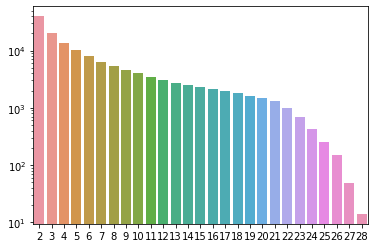

In [888]:
#we are looking at the distribution of pseudo-enhancers per cobound regions
counts,val = np.unique(merged[merged.columns[cols:annot]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.figure.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_distribution.pdf")

plotting the ratios

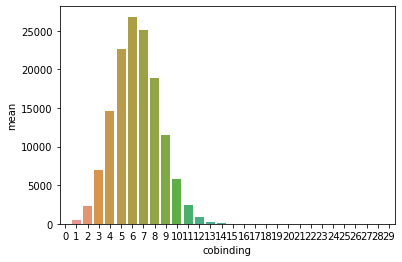

In [941]:
cobind = pd.DataFrame(sums).T.rename(columns={0:'mean',1:'var'})
cobind['cobinding']=cobind.index
fig = sns.barplot("cobinding","mean", data=cobind, ci=None)
#plt.errorbar(x=range(0,len(cobind)),y=cobind['mean'],
            #yerr=cobind['var'], fmt='none', c= 'r')
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_expected_cobinding_distribution.pdf")

Let's look at the enrichment of our current dataset

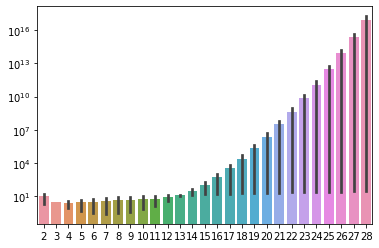

In [894]:
res = pd.DataFrame()
res['change']=val/cobind[cobind.cobinding.isin(counts)]['mean']
res['count']=list(res.index)
fig = sns.barplot(data=res.T).set_yscale("log")
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_enrichment.pdf")

### cobinding enrichment

Barplot (total + zoomed) of the enrichment in number of cobound proteins to a conscensus peak. This enrichment is computed from the expected distribution of cobindings given by the frequencies of peaks for each proteins, over the cobinding matrix. Cobound proteins are defined from called peaks, using macs2 on chipseq data.

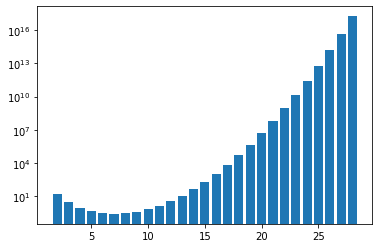

In [895]:
fig = plt.bar(res['count'],res['change'],log=True)
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window + "_cobinding_enrichment_matplotlib.pdf")
plt.show()

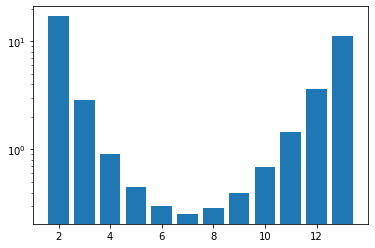

In [896]:
m =12
fig = plt.bar(res.iloc[:m]['count'],res.iloc[:m]['change'],log=True)
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_enrichment_zoomed.pdf")
plt.show()

## Saving

In [887]:
%store chrombed
%store mergedpeak
%store cols
%store annot
%store version
%store window
%store crc

Stored 'merged' (DataFrame)
Stored 'chrombed' (DataFrame)
Stored 'mergedpeak' (DataFrame)
Stored 'cols' (int)
Stored 'annot' (int)
Stored 'version' (str)
Stored 'merging_version' (str)
Stored 'window' (str)
